Installation Instructions

1.  If you wish, you can just look at the notebook without running the cells of course.
the only problem is that the anomaly pivots (where I show the cells in red if they are
an anomaly, don't actually show up red. so I'll distribute a pdf also.)

2.  I posted the materials on binder at this link: You can run the notebook from there.  
However the neural networks are very very slow there. What takes 60 seconds on my mac takes an hour there. So for that version I just used the two faster models (xgboost and  linear).  Search for the INCLUDE_MODELS variable to see that.  You can of course change that and be patient.

3.  You can install it locally.  Here are the instructions for that:

3.1.  Get jupyter notebook running on your system.  https://jupyter.org/install.  
    I use what they refer to as the 'classic jupyter notebook'.  
    prerequisite: at terminal, this does something: jupyter notebook

3.2.  Unzip all the files I gave you. This should create a directory somewhere called ml-ad

3.3.  What follows is python package silliness, frustration, and eventually slight happiness perhaps.  You have two options for this:
a.	 Do the usual thing – load up the notebook.  Keep doing pip install with each error message, googling for problems that you run into.  Eventually it should work. I put the larger package imports before the smaller ones so you probably will install in a good order using the error messages.
b.	I can’t do that as it breaks my other projects and clutters my base python environment.  So here are the instructions using conda.

If you want to do b:

3.4.  Don’t start jupyter yet.  Or stop it if you’ve started it. That way when you load the notebook it’ll find the environment and not reassign it.

3.5.  install either miniconda or anaconda  - I use miniconda since I don't want that extra stuff
     https://conda.io/projects/conda/en/latest/user-guide/install/index.html
     prerequisite: at terminal, this does something: conda env list

3.6.  Some library if I recall (I forget which) needs graphviz.  Install that:
    https://graphviz.org/download.  Or wait to see if you get an error message related to this and then install it if necessary.

3.7.  In your new directory
        conda env create -f environment.yml -v
   that will create a conda environment named ml-ad with all the python dependencies

3.8.  These steps allow jupyter notebook to use this environment:
        conda activate ml-ad
        python -m ipykernel install --user --name=ml-ad

3.9.  Now launch jupyter and pull up the notebook via:
        conda deactivate
        jupyter notebook

You can confirm that it’s connected to your kernel (or change it) via Kernel/Change Kernel.  It should say ml-ad

you should be able to run the script now.  Search for include_models – you can pick and choose models (most notably lstm adds an hour).  

now wasn't that easy? Any problems or questions about installation or what the notebook is doing feel free to contact me.

In [1]:
# conda notes
# conda create --name test_1Oct2021 python=3.7
# may need to be the same python version as base environment for graphviz - not sure.
# conda activate test_1Oct2021
# conda install ipykernel
# conda install -c anaconda ipython_genutils
# python -m ipykernel install --user --name=test_1Oct2021
# conda install -c anaconda python-graphviz
# conda install -c anaconda pydot
# conda install tensorflow
# conda install keras
# conda install xgboost
# conda install matplotlib
# conda install pandas
# conda install seaborn
# conda install Jinja2
# conda env export --from-history | grep -v "^prefix: " > environment.yml
# then edit the environment.yml file and add version numbers.

# conda env create -f environment.yml -v

# conda deactivate
# conda env remove --name test_1Oct2021

In [2]:
import time; time.ctime(); print(time.strftime('%I:%M:%S%p %Z on %b %d, %Y'))

07:50:56AM EDT on Oct 04, 2021


In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, History
from tensorflow import keras
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

import xgboost as xgb
from xgboost import plot_tree

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, \
    mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLarsCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import pandas as pd

import seaborn as sns

from pathlib import Path
import pdb
from IPython import display
import numpy as np
from datetime import datetime, timedelta
from scipy.special import softmax
import pickle
import os

Using TensorFlow backend.


In [4]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 10

PREDICT_WITH_ACTUALS = True # leave this alone.  Didn't completely implement the other 
# option - which is to use predictions as the lags for the next prediction. As is typical
# with a kaggle competition, but in reality using the actuals as they come in each day
# would be standard practice (this is how NASA did it as well)

# timing comments are for the covid data on my mac. 
# I used the top 2 during the actual class so I could quickly switch datasets.
# INCLUDE_MODELS = set(["linear", "xgboost"]) # this takes 15 seconds
# INCLUDE_MODELS = set(["linear", "xgboost", "ann"]) # this takes 96 seconds
INCLUDE_MODELS = set(["linear", "xgboost", "ann", "lstm"]) # this takes 61 minutes

ANN_EPOCHS = 1000
LSTM_EPOCHS = 35


In [5]:
import sys
IN_COLAB = 'google.colab' in sys.modules
def f(file_path):
    if IN_COLAB:
        fp2 = file_path.replace("./data2/", "https://github.com/dwoodlock/ml-ad/blob/main/data2/")
        fp3 = fp2 + "?raw=True"
        return fp3
        pdb.set_trace()
    else:
        return file_path
IN_COLAB

False

In [6]:
def image(path):
    if "https://" in path:
        return display.Image(url = path)
    else:
        return display.Image(path)

In [7]:
def original_df():
    data_path = f('./data2/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
    df = pd.read_csv(data_path)
    return df
df = original_df()
df.shape

(35040, 15)

In [8]:
# what's the last date.
sorted([pd.Period(d) for d in df['submission_date'].unique()])[-1]

Period('2021-08-27', 'D')

In [9]:
last_submission_date = sorted([pd.Period(d) for d in df['submission_date'].unique()])[-1]
last_submission_date
split_date = last_submission_date - 35
train_mask = pd.to_datetime(df['submission_date']).dt.to_period("D") < split_date
train = df[train_mask].copy()
test = df[~train_mask].copy()
train.shape, test.shape

((32880, 15), (2160, 15))

In [10]:
# nyc is separate from ny in this dataset.
def combine_ny(df):    
    # add NYC into NY
    mask = df['state'] == 'NY'
    mask2 = df['state'] == 'NYC'
    new_yorks = df[mask | mask2]
    new_yorks = new_yorks.groupby('submission_date').sum()
    new_yorks['state'] = 'NY'
    new_yorks.reset_index(inplace=True) # move submission date into a column again
    new_yorks
    # remove existing NY and NYC from df
    df2 = df[~(mask | mask2)]
    df2 = df2[new_yorks.columns].append(new_yorks)
    # add in the aggregated one
    return df2

In [11]:
def add_in_population(df):
    population_df = pd.read_csv(f('./data2/nst-est2019-01.csv'), 
                                usecols=['state', 'Population'])
    population_df['Population'] = population_df['Population'].str.replace(",", "").astype(int)
    return df.merge(population_df, on='state', how='left')

In [12]:
# add in rolling averages
def add_rolling(df, background_df):
    
    first_date = None
    if set(df['submission_date'].unique()) != set(background_df['submission_date'].unique()):
        first_date = sorted(df['submission_date'].unique())[0]
        df = df.append(background_df)
        df.reset_index(inplace=True)

    df.sort_values(['submission_date', 'state'], inplace=True)
    df_rolling = df[['state', 'new_case']].groupby('state')['new_case'].rolling(7).mean()
    df_rolling.index = df_rolling.index.droplevel()

    df['new_case_rolling_7_days'] = df_rolling
    if first_date is not None:
        df = df[df['submission_date'] >= first_date].copy() # strip off background data
    return df

In [13]:
def _fix_submission_date(df):
    df['submission_date'] = pd.to_datetime(df['submission_date']).dt.to_period("D")
    return df

class Pipeline:
        
    def fit(self, df):
        df2 = df.copy() # make sure I don't accidentally change.
        df2 = _fix_submission_date(df2)
        df2.fillna(0, inplace=True)
        self.train_post_ny = combine_ny(df2)
        self.last_submission_date = sorted(
            [pd.Period(d) for d in df['submission_date'].unique()])[-1]
        self.state2num = {c: i for i, c in enumerate(train['state'].unique())}
        print("MA encoded = ", self.state2num['MA'])
        self.state_stats = (df2[df2['submission_date'] >= pd.Period('2021-01-01')]
               .groupby('state')['new_case']
               .agg(['mean', 'std', 'median', lambda x: x.quantile(0.1), 
                     lambda x: x.quantile(0.9)]))
        self.state_stats.rename(
            columns={
                "<lambda_0>": "state_10%_percentile", 
                "<lambda_1>": "state_90%_percentile",
                "mean": "state_mean",
                "std": "state_std",
                "median": "state_median"}, inplace=True)
    
    def transform(self, df):
        df = _fix_submission_date(df)
        df.fillna(0, inplace=True)
        df = combine_ny(df)
        df = add_in_population(df)
        df = add_rolling(df, self.train_post_ny)
        df['submission_date_day_of_year'] = df['submission_date'].dt.dayofyear
        df['submission_date_month'] = df['submission_date'].dt.month
        df['submission_date_day_of_week'] = df['submission_date'].dt.dayofweek
        df['submission_date_year'] = df['submission_date'].dt.year
        df['state_encoded'] = df['state'].map(self.state2num)
        df = df.merge(self.state_stats, on='state', how='left')
        return df

In [14]:
myPipeline = Pipeline()
myPipeline.fit(train)
train = myPipeline.transform(train)

MA encoded =  15


In [15]:
# there are 13 metrics, 58 states and territories, and 584 days of data. This is small (440K data points)
df['submission_date'] = pd.to_datetime(df['submission_date'])
df.sort_values(['submission_date', 'state']).to_csv('data_one.csv', index=False)
df.sort_values(['submission_date', 'state']).iloc[10000:].reset_index(drop=True)


submission_date state  tot_cases  conf_cases  prob_cases  new_case  \
0          2020-07-06    OH      57956     54232.0      3724.0       805   
1          2020-07-06    OK      23006         NaN         NaN       495   
2          2020-07-06    OR      10395      9902.0       493.0       165   
3          2020-07-06    PA      91299     88691.0      2608.0       995   
4          2020-07-06    PR       2480      2479.0         1.0        15   
...               ...   ...        ...         ...         ...       ...   
25035      2021-08-27    VT      25751         NaN         NaN         0   
25036      2021-08-27    WA     550988         NaN         NaN      4267   
25037      2021-08-27    WI     727353    655667.0     71686.0      2636   
25038      2021-08-27    WV     184682    142902.0     41780.0      1328   
25039      2021-08-27    WY      73467     60684.0     12783.0       472   

       pnew_case  tot_death  conf_death  prob_death  new_death  pnew_death  \
0           31.0       2927      2677.0       250.0         16         0.0   
1            0.0        461       459.0         2.0          6         0.0   
2          493.0        215       212.0         3.0          0         3.0   
3            9.0       6787         NaN         NaN         33       -16.0   
4            0.0        164        66.0        98.0          1         0.0   
...          ...        ...         ...         ...        ...         ...   
25035        0.0        264         NaN         NaN          0         0.0   
25036      608.0       6507         NaN         NaN         36         0.0   
25037      332.0       8438      7577.0       861.0          9         2.0   
25038      321.0       3054         NaN         NaN          5         0.0   
25039      105.0        835       835.0         0.0          0         0.0   

                   created_at consent_cases consent_deaths  
0      07/07/2020 02:58:02 PM         Agree          Agree  
1      07/07/2020 12:00:00 AM     Not agree          Agree  
2      07/07/2020 02:58:02 PM         Agree          Agree  
3      07/07/2020 02:58:02 PM         Agree      Not agree  
4      07/06/2020 12:00:00 AM         Agree          Agree  
...                       ...           ...            ...  
25035  08/28/2021 01:53:26 PM     Not agree      Not agree  
25036  08/28/2021 01:53:26 PM           NaN            NaN  
25037  08/28/2021 01:53:26 PM         Agree          Agree  
25038  08/28/2021 01:53:26 PM         Agree      Not agree  
25039  08/28/2021 01:53:26 PM         Agree          Agree  

[25040 rows x 15 columns]

In [16]:
# uncomment if you want to notebook to launch excel to view it there.
# os.system("open -a 'Microsoft Excel' './data_one.csv'");

In [17]:
# look at all the data for just one metric

In [18]:
# turn it sideways
pivot_df = train[['submission_date', 'state', 'new_case']].pivot(
    index='state', columns='submission_date', values='new_case')
pivot_df.to_csv('pivot_df.csv')
pivot_df['state'] = pivot_df.index
with pd.option_context("display.max_rows", 50):
    display.display(pivot_df.head(50))

submission_date  2020-01-22  2020-01-23  2020-01-24  2020-01-25  2020-01-26  \
state                                                                         
AK                        0           0           0           0           0   
AL                       33           1           0           3           0   
AR                        0           0           0           0           0   
AS                        0           0           0           0           0   
AZ                        0           0           0           0           1   
CA                        0           0           0           0           2   
CO                        0           0           0           0           0   
CT                        0           0           0           0           0   
DC                        0           0           0           0           0   
DE                        0           0           0           0           0   
FL                        0           0           0           0           0   
FSM                       0           0           0           0           0   
GA                        0           0           0           0           0   
GU                        0           0           0           0           0   
HI                        0           0           0           0           0   
IA                        0           0           0           0           0   
ID                        0           0           0           0           0   
IL                        0           0           1           0           0   
IN                        0           0           0           0           0   
KS                        0           0           0           0           0   
KY                        0           0           0           0           0   
LA                        0           0           0           0           0   
MA                        0           0           0           0           0   
MD                        0           0           0           0           0   
ME                        0           0           0           0           0   
MI                        0           0           0           0           0   
MN                        0           0           0           0           0   
MO                        0           0           0           0           0   
MP                        0           0           0           0           0   
MS                        0           0           0           0           0   
MT                        0           0           0           0           0   
NC                        0           0           0           0           0   
ND                        0           0           0           0           0   
NE                        0           0           0           0           0   
NH                        0           0           0           0           0   
NJ                        0           0           0           0           0   
NM                        0           0           0           0           0   
NV                        0           0           0           0           0   
NY                        0           0           0           0           0   
OH                        0           0           0           0           0   
OK                        0           0           0           0           0   
OR                        0           0           0           0           0   
PA                        0           0           0           0           0   
PR                        0           0           0           0           0   
PW                        0           0           0           0           0   
RI                        0           0           0           0           0   
RMI                       0           0           0           0           0   
SC                        0           0           0           0           0   
SD                        0           0           

In [19]:
# os.system("open -a 'Microsoft Excel' './pivot_df.csv'");

In [20]:
# now can you spot the anomalies?

In [21]:
# graph a line or two.

In [22]:
# let's pick a row and visualize it to look for problems. 

In [23]:
(train[train['state'] == 'MA'][['submission_date', 'new_case']]
 .sort_values('submission_date')
 .rename(columns={"new_case": "MA new cases"})
 .to_csv('MA_new_cases.csv', index=False)
)

In [24]:
# do you see any problems?

In [25]:
# change to rolling 7 day average
(train[train['state'] == 'MA'][['submission_date', 'new_case_rolling_7_days']]
 .sort_values('submission_date')
 .rename(columns={"new_case_rolling_7_days": "MA new cases rolling 7 days"})
 .to_csv('MA_new_cases_rolling.csv', index=False)
)


In [26]:
pivot_df = train[['submission_date', 'state', 'new_case_rolling_7_days']].pivot(
    index='state', columns='submission_date', values='new_case_rolling_7_days')
pivot_df.to_csv('pivot_df2.csv')
pivot_df['state'] = pivot_df.index
pivot_df

submission_date  2020-01-22  2020-01-23  2020-01-24  2020-01-25  2020-01-26  \
state                                                                         
AK                      NaN         NaN         NaN         NaN         NaN   
AL                      NaN         NaN         NaN         NaN         NaN   
AR                      NaN         NaN         NaN         NaN         NaN   
AS                      NaN         NaN         NaN         NaN         NaN   
AZ                      NaN         NaN         NaN         NaN         NaN   
...                     ...         ...         ...         ...         ...   
VT                      NaN         NaN         NaN         NaN         NaN   
WA                      NaN         NaN         NaN         NaN         NaN   
WI                      NaN         NaN         NaN         NaN         NaN   
WV                      NaN         NaN         NaN         NaN         NaN   
WY                      NaN         NaN         NaN         NaN         NaN   

submission_date  2020-01-27  2020-01-28  2020-01-29  2020-01-30  2020-01-31  \
state                                                                         
AK                      NaN    0.000000    0.000000    0.000000    0.000000   
AL                      NaN    5.571429    1.000000    1.142857    1.428571   
AR                      NaN    0.000000    0.000000    0.000000    0.000000   
AS                      NaN    0.000000    0.000000    0.000000    0.000000   
AZ                      NaN    0.142857    0.142857    0.142857    0.142857   
...                     ...         ...         ...         ...         ...   
VT                      NaN    0.000000    0.000000    0.000000    0.000000   
WA                      NaN    0.142857    0.142857    0.000000    0.000000   
WI                      NaN    0.000000    0.000000    0.000000    0.000000   
WV                      NaN    0.000000    0.000000    0.000000    0.000000   
WY                      NaN    0.000000    0.000000    0.000000    0.000000   

submission_date  2020-02-01  2020-02-02  2020-02-03  2020-02-04  2020-02-05  \
state                                                                         
AK                 0.000000    0.000000         0.0         0.0         0.0   
AL                 1.428571    1.571429         2.0         2.0         2.0   
AR                 0.000000    0.000000         0.0         0.0         0.0   
AS                 0.000000    0.000000         0.0         0.0         0.0   
AZ                 0.142857    0.000000         0.0         0.0         0.0   
...                     ...         ...         ...         ...         ...   
VT                 0.000000    0.000000         0.0         0.0         0.0   
WA                 0.000000    0.000000         0.0         0.0         0.0   
WI                 0.000000    0.000000         0.0         0.0         0.0   
WV                 0.000000    0.000000         0.0         0.0         0.0   
WY                 0.000000    0.000000         0.0         0.0         0.0   

submission_date  2020-02-06  2020-02-07  2020-02-08  2020-02-09  2020-02-10  \
state                                                                         
AK                 0.000000    0.000000    0.000000    0.000000    0.000000   
AL                 1.714286    1.428571    1.142857    1.285714    0.857143   
AR                 0.000000    0.000000    0.000000    0.000000    0.000000   
AS                 0.000000    0.000000    0.000000    0.000000    0.000000   
AZ                 0.000000    0.000000    0.000000    0.000000    0.000000   
...                     ...         ...         ...         ...         ...   
VT                 0.000000    0.000000    0.000000    0.000000    0.000000   
WA                 0.000000    0.000000    0.000000    0.000000    0.000000   
WI                 0.000000    0.000000    0.000000    0.000000    0.000000   
WV                 0.000000    0.000000    0.00

In [27]:
# os.system("open -a 'Microsoft Excel' './pivot_df2.csv'");

In [28]:
test = myPipeline.transform(test)

In [29]:
# 1.  make up a rule and test for data points that don't meet that rule

In [30]:
# for example cases / 100K > 50 is an anomaly.  From the CDC.

In [31]:
# new case average in the past 7 days > 50 per 100k residents
test['anomaly_by_rule'] = (test['new_case_rolling_7_days'] 
                           / test['Population']) * 100000 > 50

In [32]:
def show_anomaly_pivot(anomaly_col):
    def highlight_anomaly(row):
        highlight = 'background-color: lightcoral;'
        default = ''
        styles = []
        for col, date in row.index:
            if col == 'new_case_rolling_7_days' and row[(anomaly_col, date)]:
                styles.append(highlight)
            else:
                styles.append(default)
        return styles
    
    test2 = test.copy()
    test2['new_case_rolling_7_days'] = test2['new_case_rolling_7_days'].astype(int)

    test_pivot = (test2[['submission_date', 'state', 'new_case_rolling_7_days', anomaly_col]]
     .pivot(index='state', columns='submission_date', values=['new_case_rolling_7_days', anomaly_col])
    )
    test_pivot.reset_index(inplace=True)
    test_pivot['State'] = test_pivot['state']
    hidden_cols = [c for c in test_pivot.columns if c[0] == anomaly_col]
    test_style = (test_pivot
     .style.apply(highlight_anomaly, axis=1)
     .hide_columns(hidden_cols)
    )
    return test_style


In [33]:
def save_state(state, extra_cols):

    assert type(extra_cols) == list
    cols = ['state', 'submission_date', 'new_case_rolling_7_days'] + extra_cols
    train_copy = train.copy()
    for col in extra_cols:
        if col not in train:
            train[col] = None
    all_df = train[cols].append(test[cols])


    (all_df[all_df['state'] == state]
     .drop(columns='state')
     .sort_values('submission_date')
     .rename(columns={"new_case_rolling_7_days": f"{state} new cases rolling 7 days"})
     .to_csv(f'{state}_new_cases_rolling.csv', index=False)
    )
save_state('NC', ['anomaly_by_rule'])

In [34]:
# you can look at in excel as NC_new_cases_rolling.csv for example
# I graphed in excel in advance and then saved as image files for this section

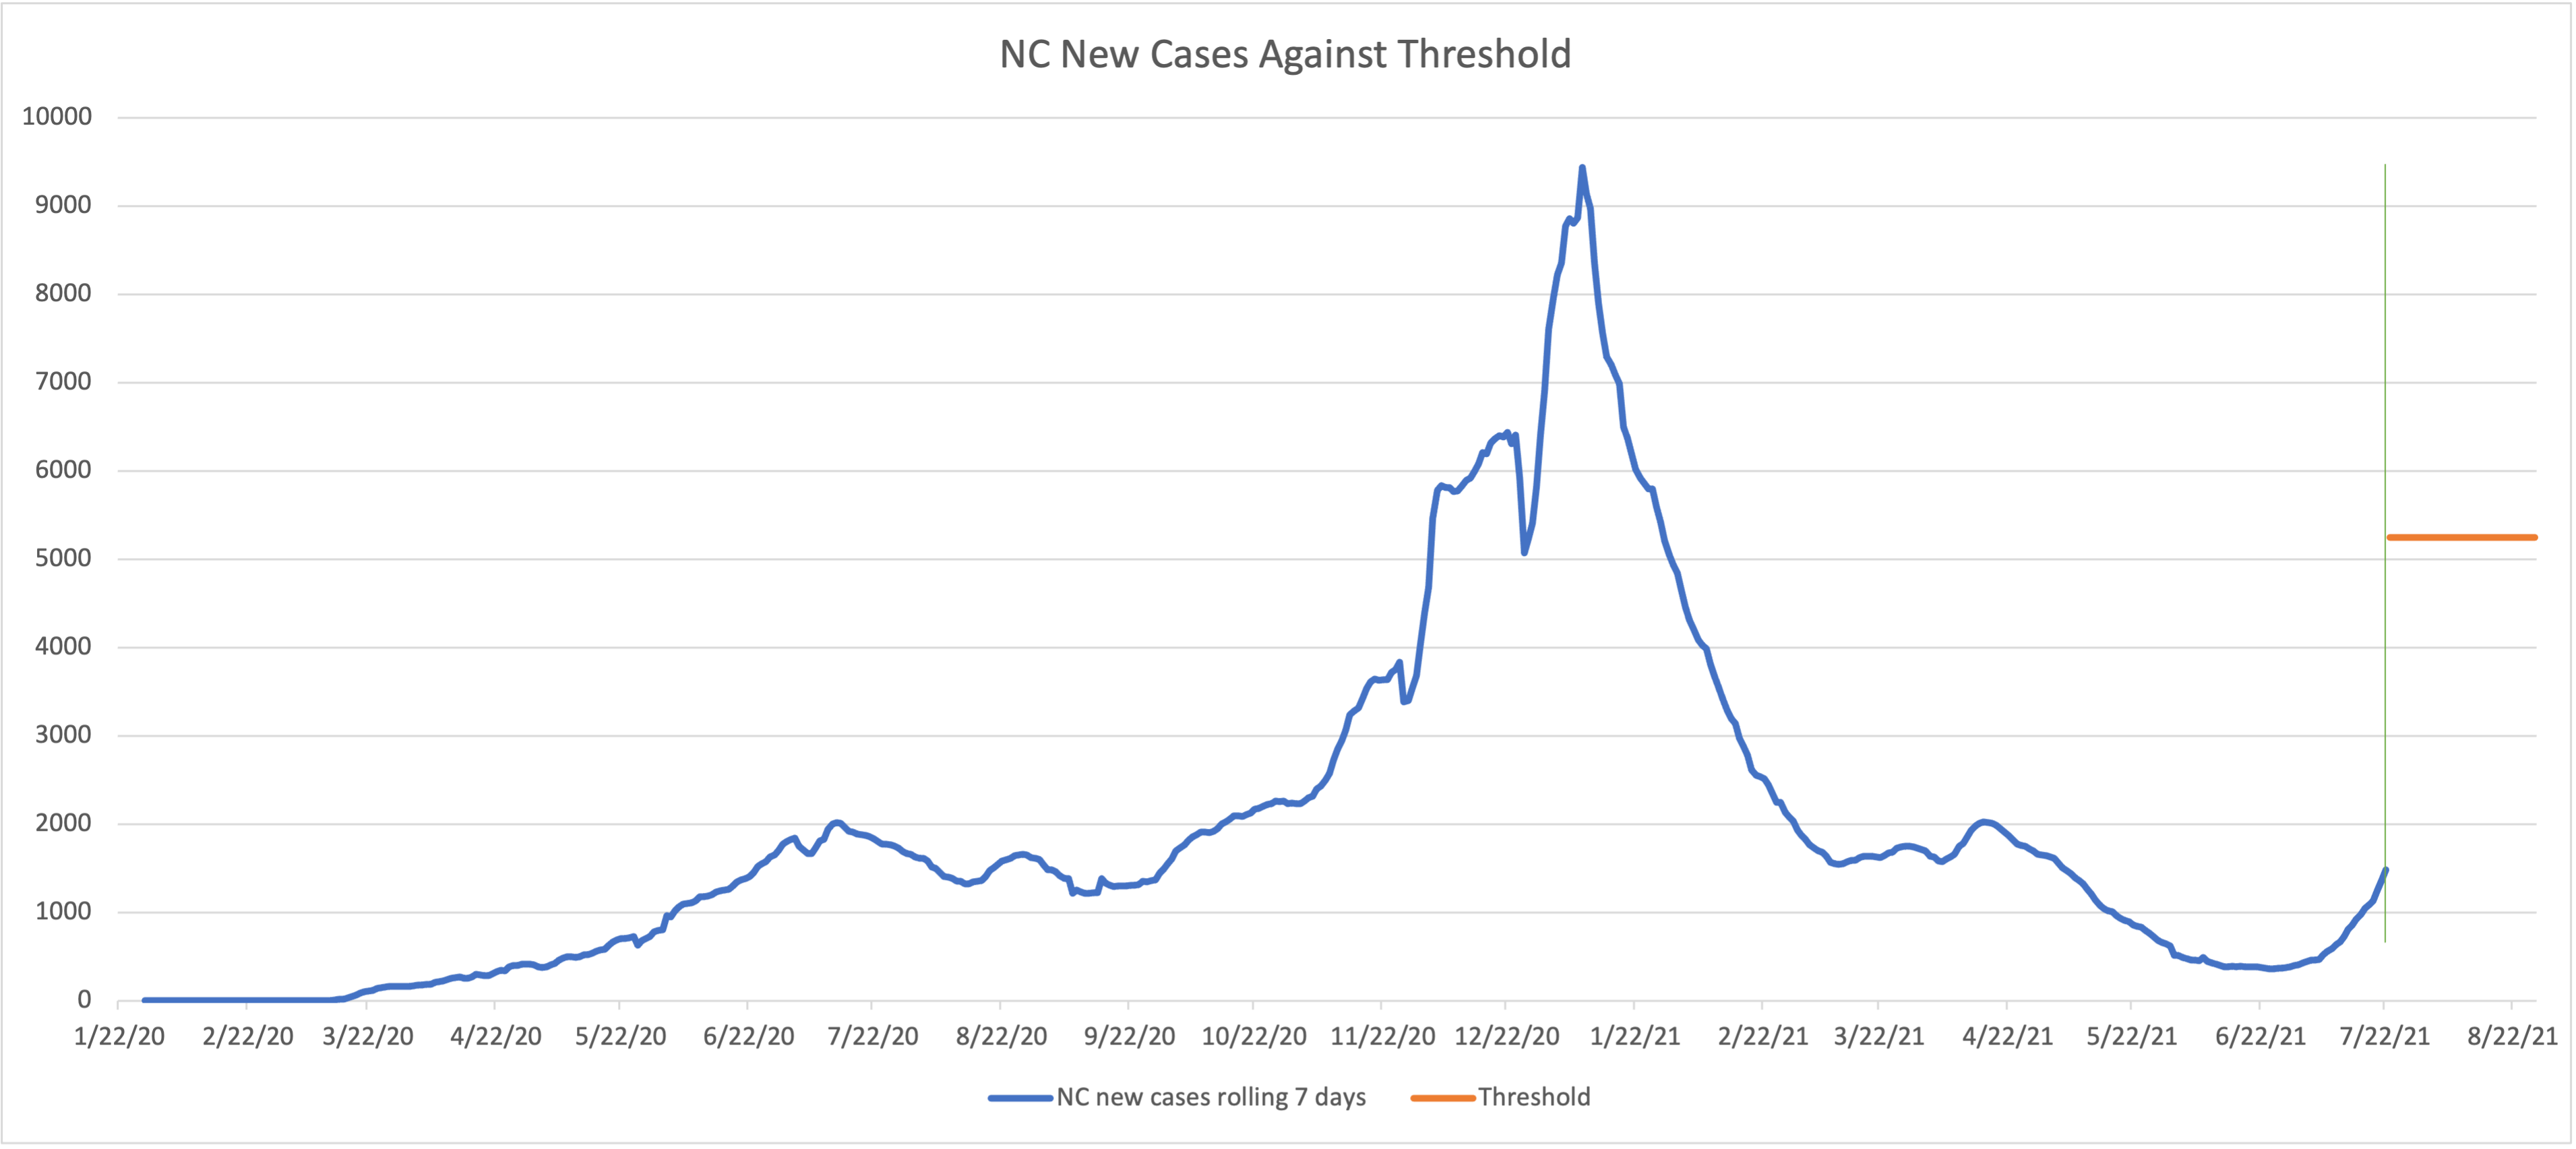

In [35]:
image(f('./data2/NC_New_Cases_Against_Target_1.png'))

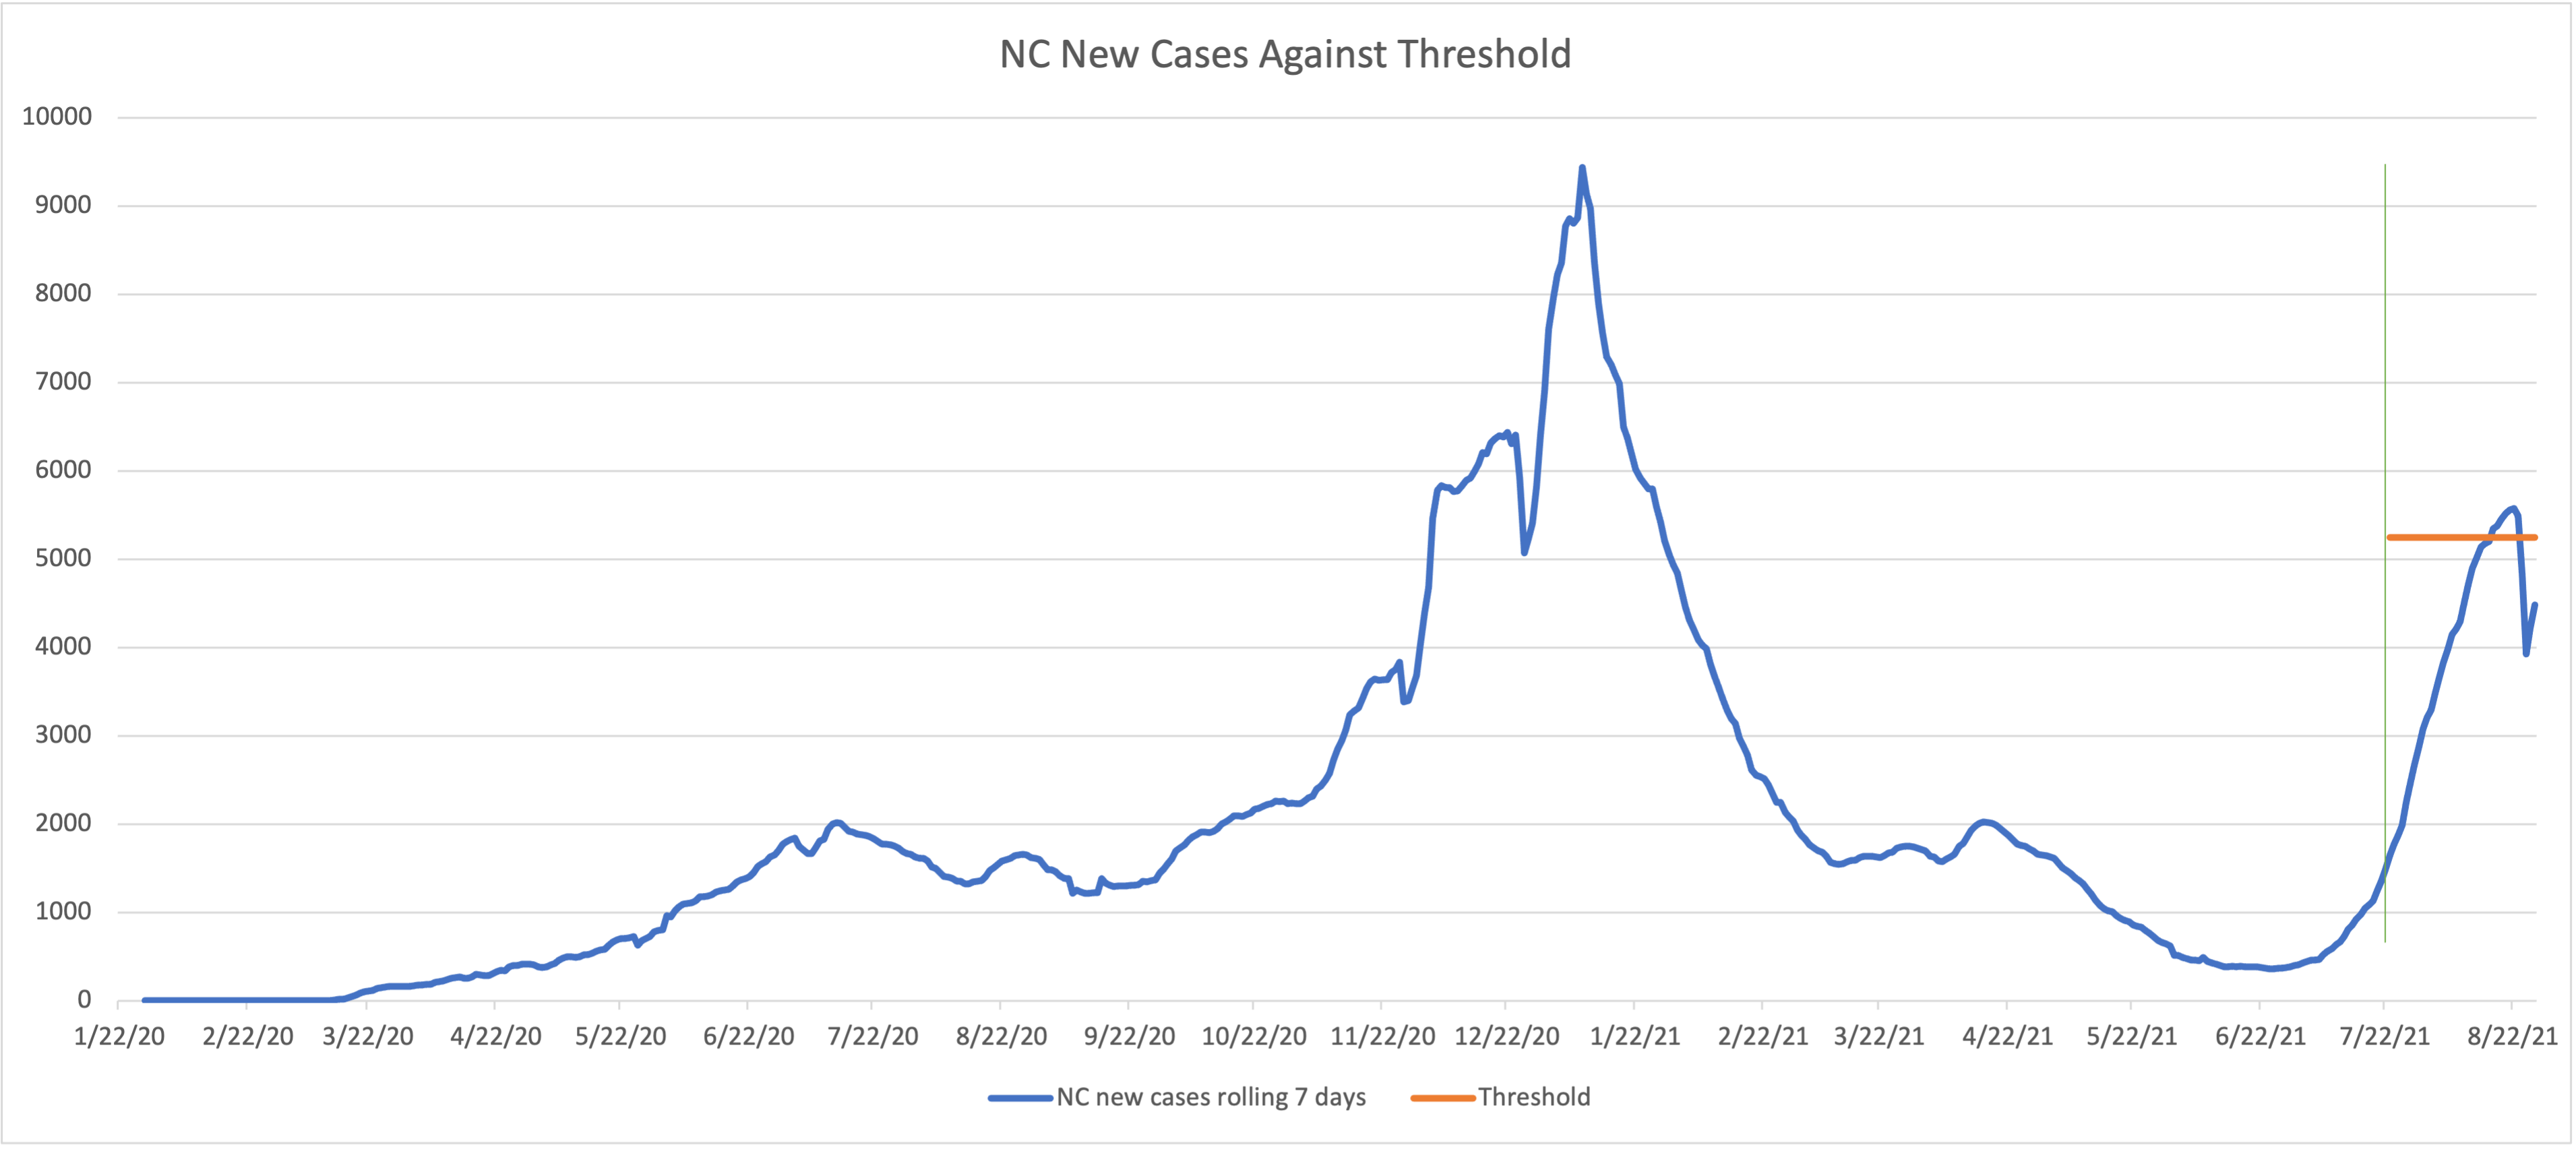

In [36]:
image(f('./data2/NC_New_Cases_Against_Target_2.png'))

In [37]:
show_anomaly_pivot('anomaly_by_rule') # search by rule

In [38]:
# what if it's not feasible to go metric by metric and set the definition of an anomaly.  

In [39]:
# 2.  Establish a mean and report an anomaly as 2 stds away from the mean

# in the covid data case, I actually used median and then 10% and 90% pecentile as the limits
# because the data was not normal (in the Gaussian sense). You can automatically add a check
# if the data is normal (there are some python stat libraries for that) and just use mean/std
# or median/percentiles depending.

# I believe that's the way to handle this scenario.

In [40]:
test['new_case_z_score'] = (
    test['new_case_rolling_7_days'] - test['state_mean']).clip(lower=0) / test['state_std']
test;

In [41]:
test['anomaly_by_mean'] = ((test['new_case_rolling_7_days'] > test['state_90%_percentile']) | (
    test['new_case_rolling_7_days'] < test['state_10%_percentile']))

In [42]:
save_state('KY', ['anomaly_by_mean'])

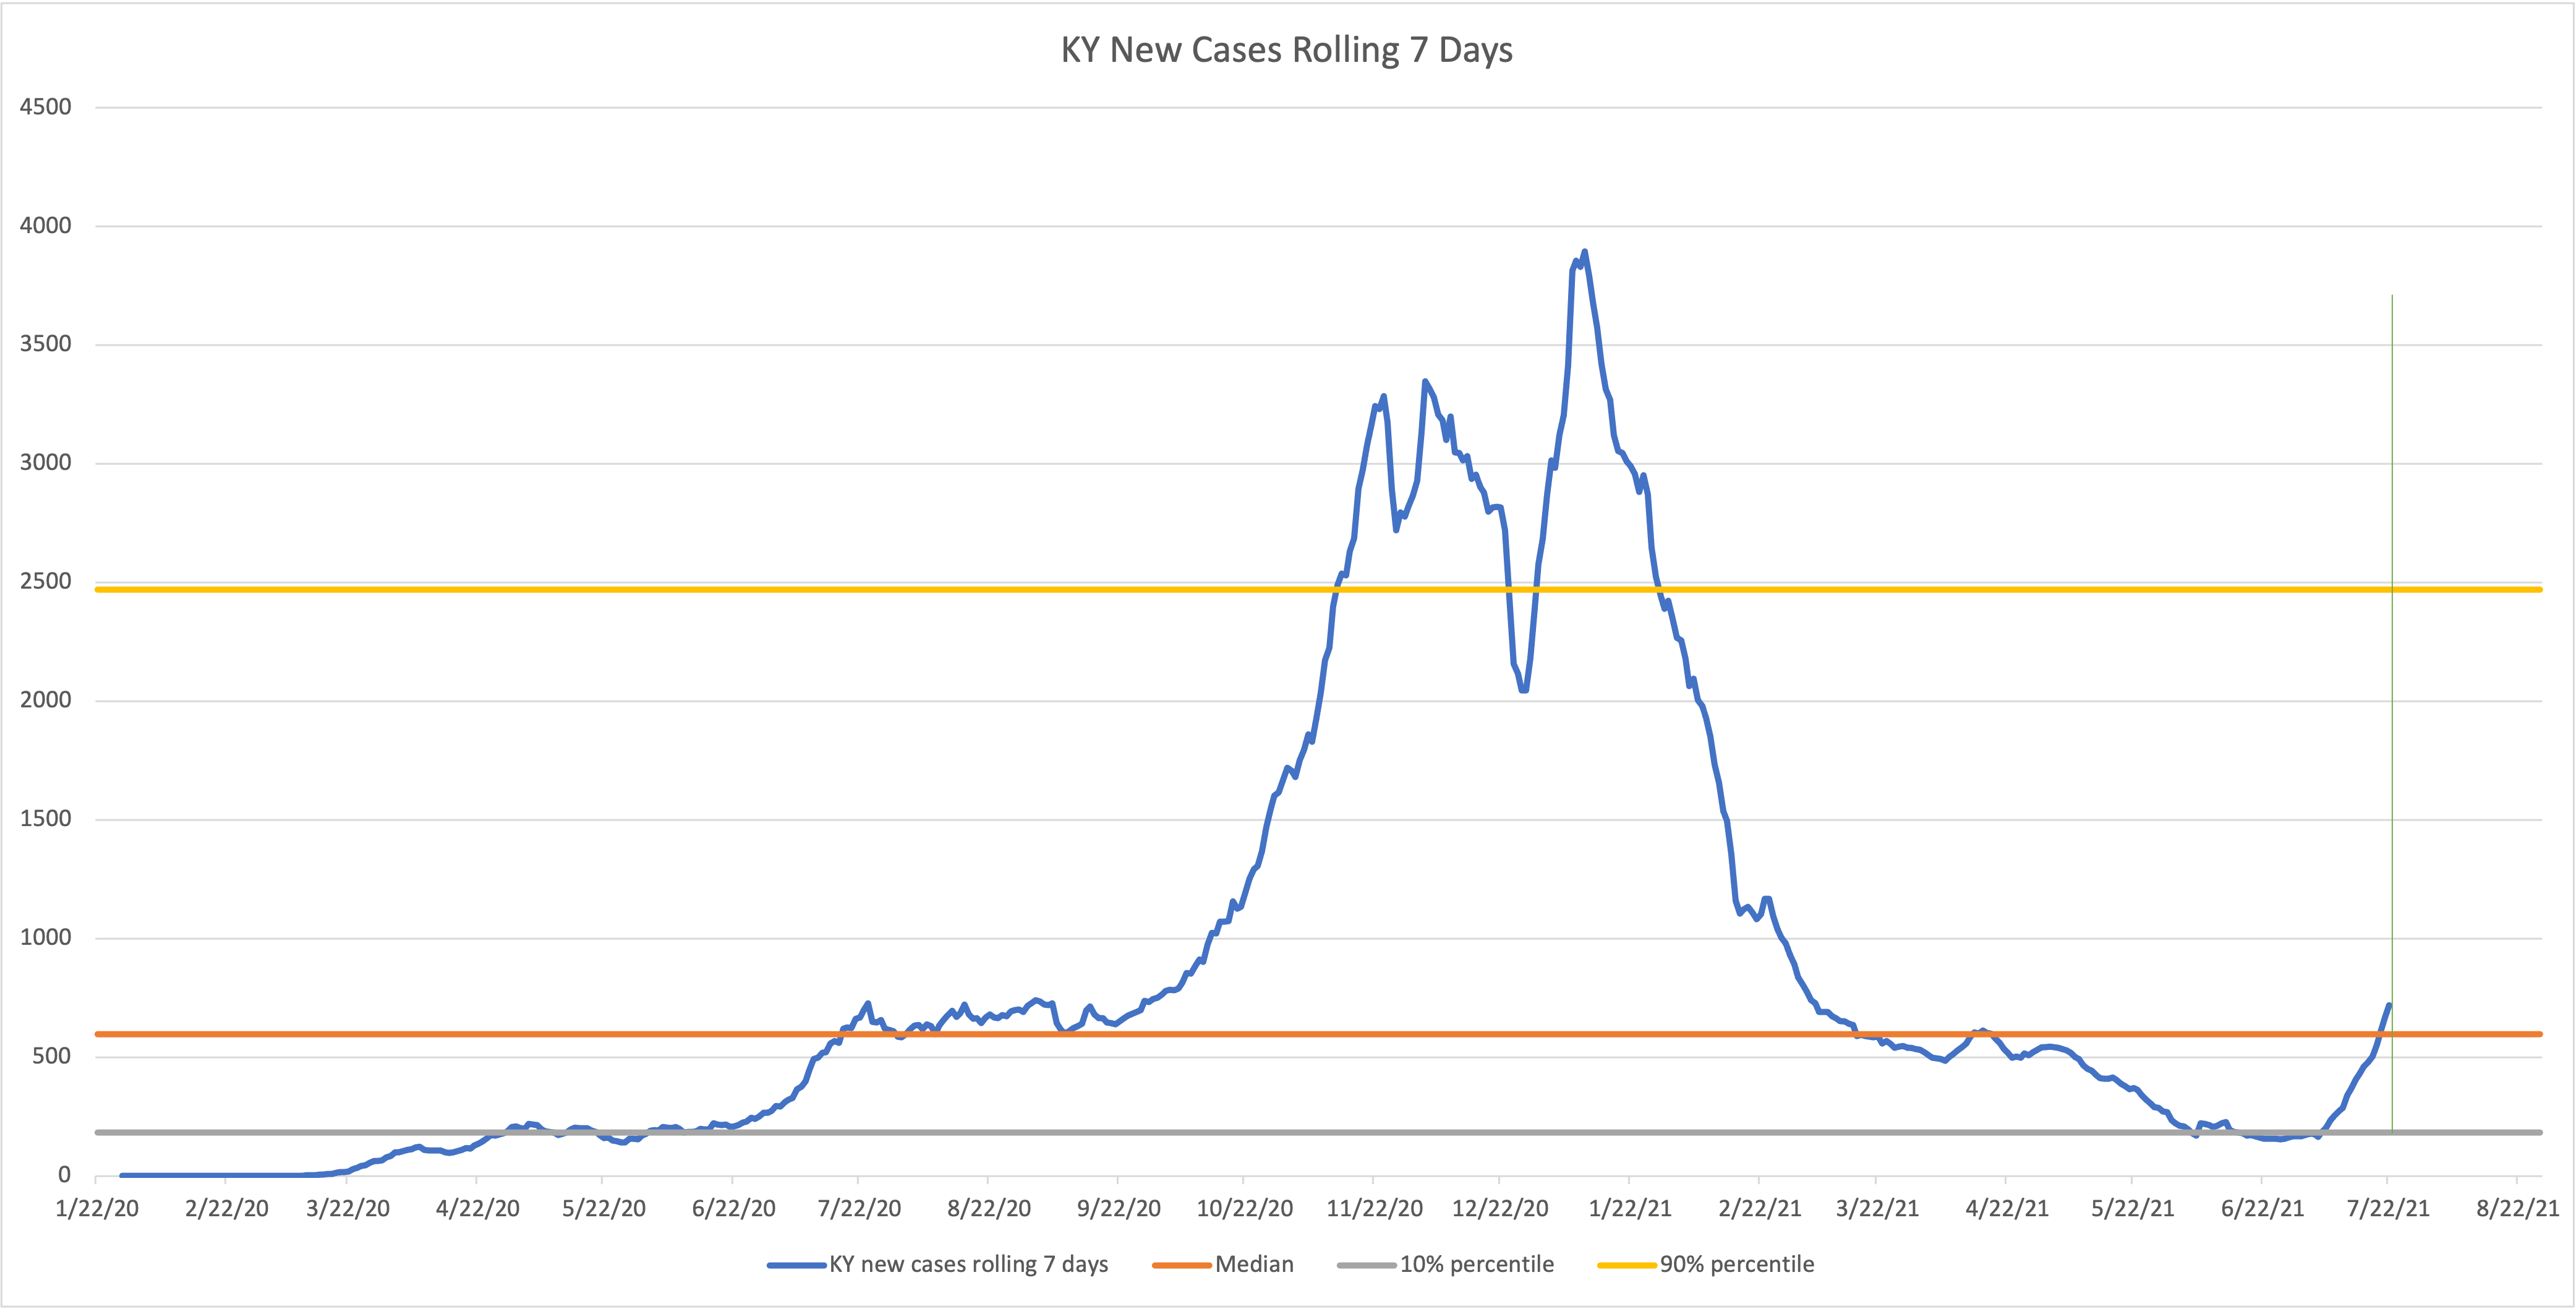

In [43]:
image(f('./data2/KY New cases Median 1.png'))

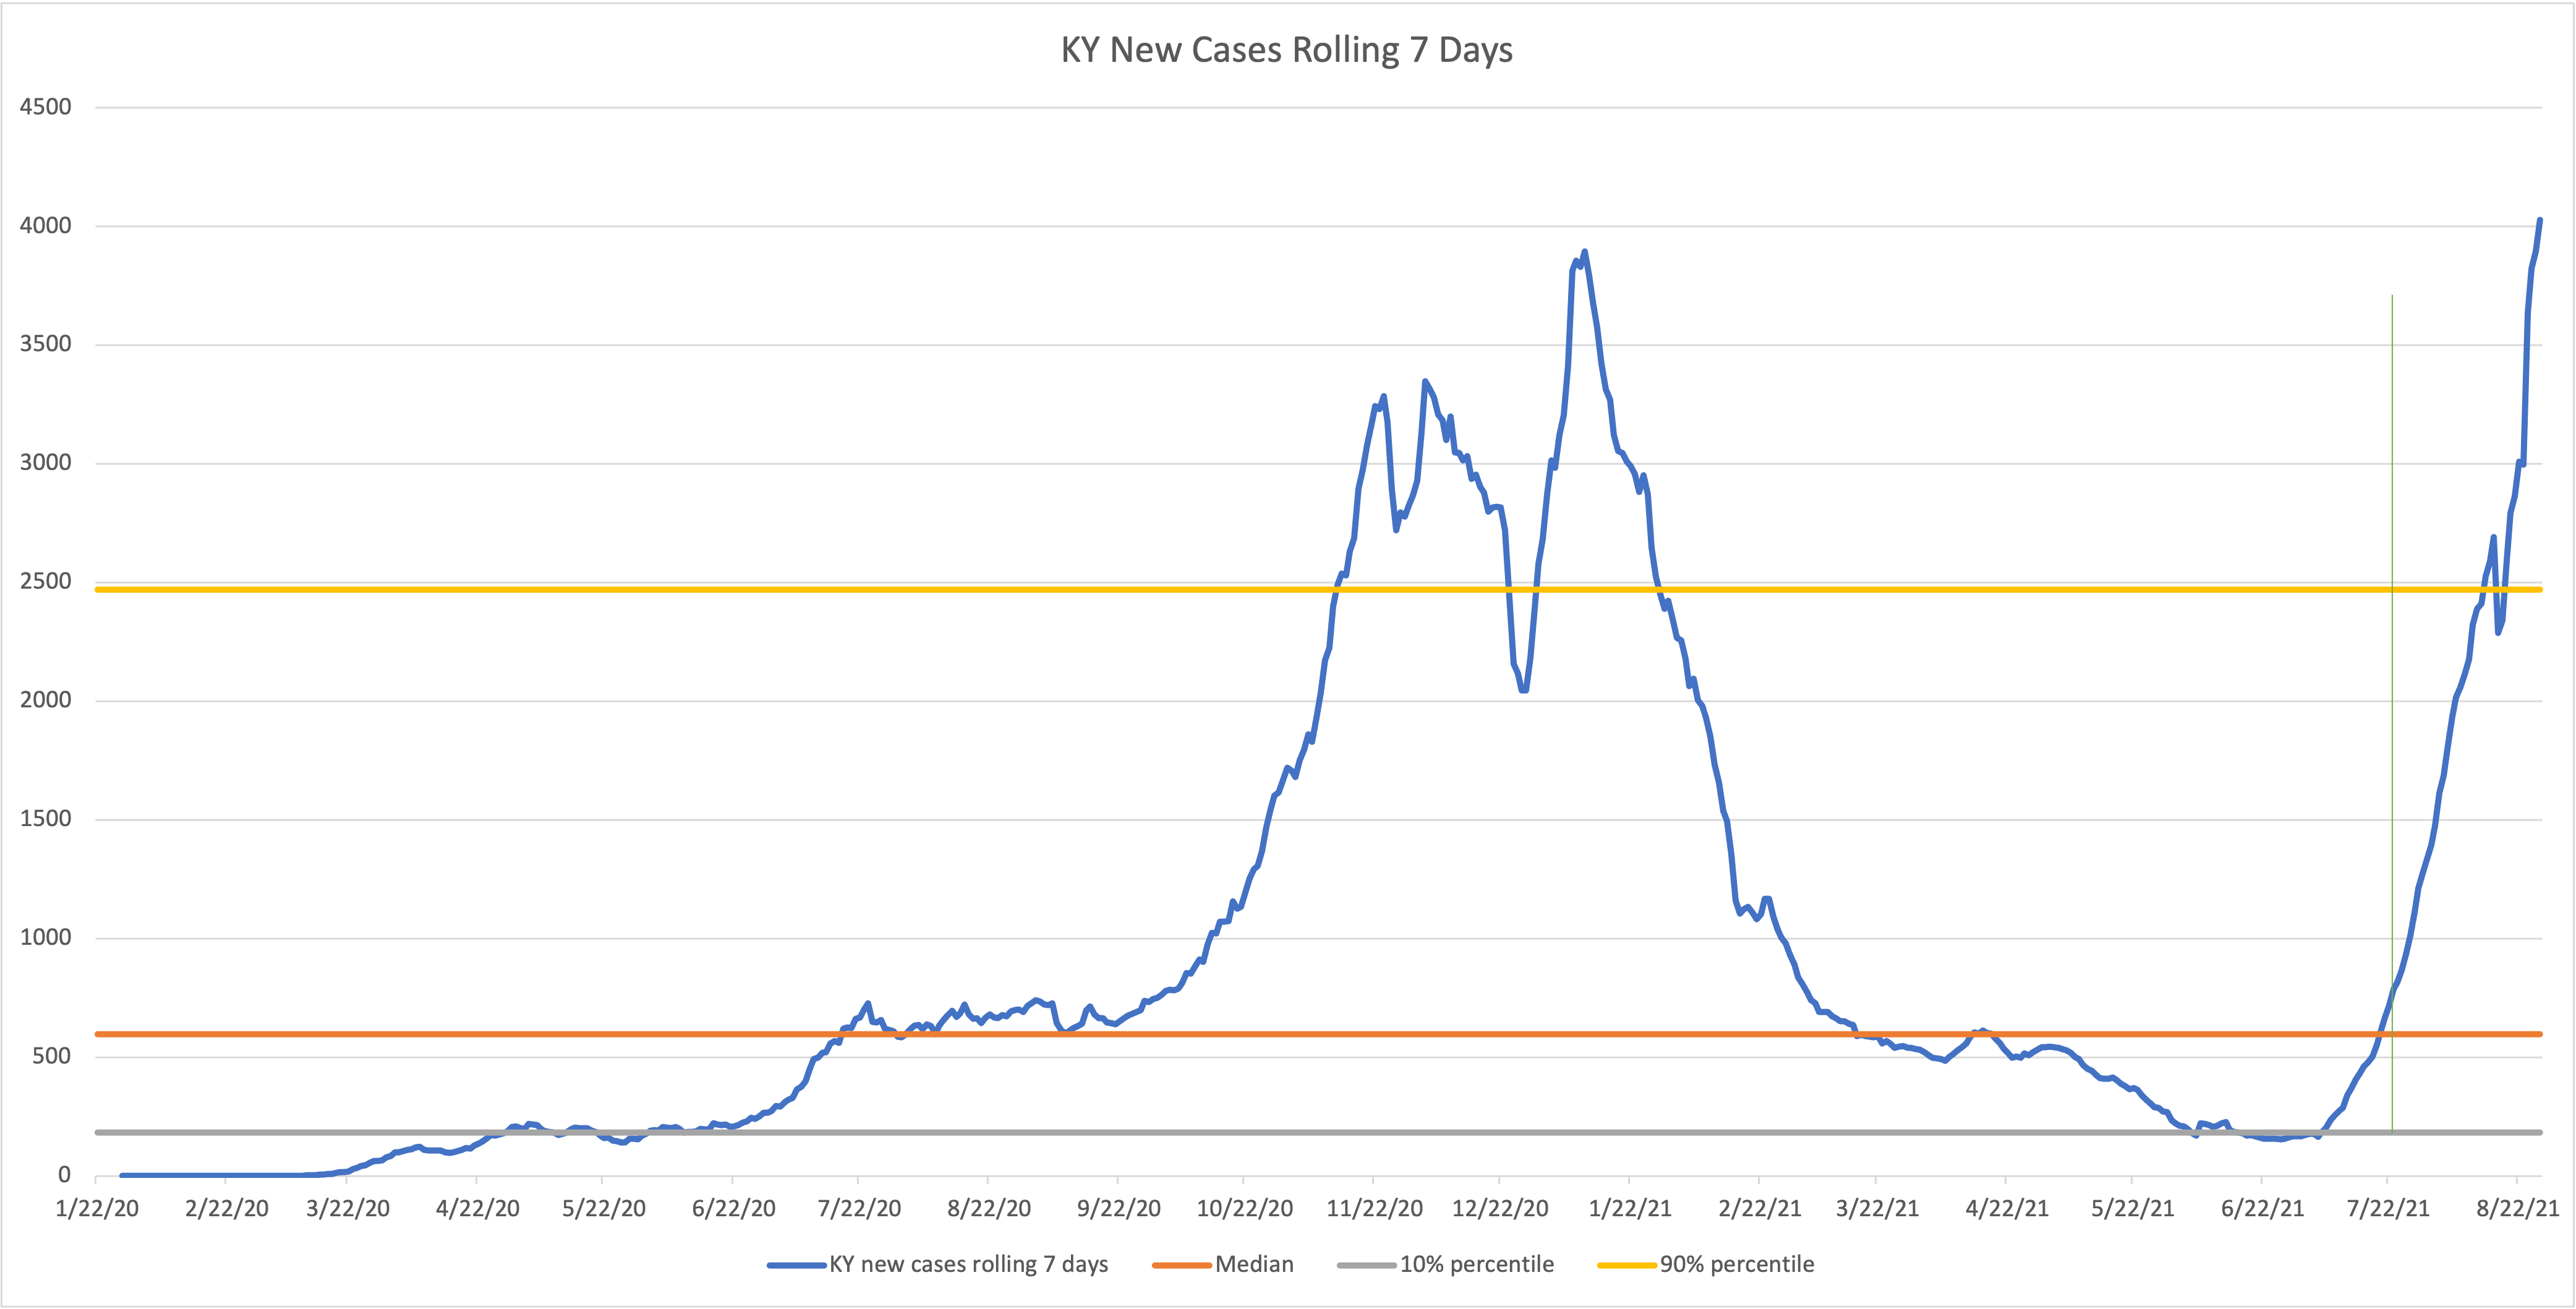

In [44]:
image(f('./data2/KY New cases Median 2.png'))

In [45]:
show_anomaly_pivot('anomaly_by_mean') # search by mean

In [46]:
# ok to recap:
# for metrics where you are 'Managing for Control', we want to ensure that we are staying 
# 'in control' and identify
# when we are not - an anomaly.  

# We can:
# 1.  Set rules.  Like when this metric goes higher than X, tell me.  
# 2.  Automatically generate upper and lower control limits from mean/std (or median/percentiles).  And tell me
# when any of my metrics have fallen outside that range.
# 3.  What if it's a number that is normally increasing?  Like # of messages from a clinic 
# that is ordinarily 
# growing.  Or revenue.  Or incoming service tickets from a growing customer base?
#  Instead of staying in the mean, we could calculate the slope and make sure future data 
# points stay within
#  that slope.  




In [47]:
# managing by slope.  

In [48]:
train[train['state'] == 'MA'][['submission_date', 'new_case_rolling_7_days']].tail(10)

submission_date  new_case_rolling_7_days
31764      2021-07-13               145.428571
31823      2021-07-14               165.285714
31882      2021-07-15               187.714286
31941      2021-07-16               206.000000
32000      2021-07-17               226.714286
32059      2021-07-18               247.428571
32118      2021-07-19               267.857143
32177      2021-07-20               291.857143
32236      2021-07-21               334.000000
32295      2021-07-22               373.285714

In [49]:
slope_horizon = 4

In [50]:
train['new_case_rolling_lagged'] = train.groupby(
    'state')["new_case_rolling_7_days"].transform(lambda x:x.shift(slope_horizon))

In [51]:
train['new_case_slope'] = (train['new_case_rolling_7_days'] - train['new_case_rolling_lagged']) / slope_horizon

In [52]:
train[train['state'] == 'MA'][[
    'submission_date', 'new_case_rolling_7_days', 'new_case_rolling_lagged', 'new_case_slope']].tail(10)

submission_date  new_case_rolling_7_days  new_case_rolling_lagged  \
31764      2021-07-13               145.428571                98.857143   
31823      2021-07-14               165.285714               104.285714   
31882      2021-07-15               187.714286               109.714286   
31941      2021-07-16               206.000000               115.428571   
32000      2021-07-17               226.714286               145.428571   
32059      2021-07-18               247.428571               165.285714   
32118      2021-07-19               267.857143               187.714286   
32177      2021-07-20               291.857143               206.000000   
32236      2021-07-21               334.000000               226.714286   
32295      2021-07-22               373.285714               247.428571   

       new_case_slope  
31764       11.642857  
31823       15.250000  
31882       19.500000  
31941       22.642857  
32000       20.321429  
32059       20.535714  
32118       20.035714  
32177       21.464286  
32236       26.821429  
32295       31.464286

In [53]:
slope_by_state = {}
for state in train['state'].unique():
    last_row =  train[train['state'] == state].iloc[-1]
    last_slope = last_row['new_case_slope']
    last_new_cases = last_row['new_case_rolling_7_days']
    last_submission_date = last_row['submission_date']
    slope_by_state[state] = (last_new_cases, last_slope, last_submission_date)
slope_by_state    

{'AK': (174.14285714285714, 13.25, Period('2021-07-22', 'D')),
 'AL': (1423.7142857142858, 129.39285714285717, Period('2021-07-22', 'D')),
 'AR': (1298.2857142857142, 57.5, Period('2021-07-22', 'D')),
 'AS': (0.0, 0.0, Period('2021-07-22', 'D')),
 'AZ': (1112.5714285714287, 34.96428571428575, Period('2021-07-22', 'D')),
 'CA': (6613.142857142857, 344.6071428571429, Period('2021-07-22', 'D')),
 'CO': (467.85714285714283, 17.535714285714278, Period('2021-07-22', 'D')),
 'CT': (184.14285714285714, 12.82142857142857, Period('2021-07-22', 'D')),
 'DC': (45.0, 2.5, Period('2021-07-22', 'D')),
 'DE': (48.857142857142854, 1.0357142857142847, Period('2021-07-22', 'D')),
 'FL': (10453.142857142857, 656.4642857142856, Period('2021-07-22', 'D')),
 'FSM': (0.14285714285714285, 0.0, Period('2021-07-22', 'D')),
 'GA': (1474.0, 97.14285714285717, Period('2021-07-22', 'D')),
 'GU': (3.4285714285714284, 0.0, Period('2021-07-22', 'D')),
 'HI': (138.0, 9.785714285714285, Period('2021-07-22', 'D')),
 'IA':

In [54]:
def fn(row):
    submission_date = row['submission_date']
    state = row['state']
    start_new_cases, slope, date = slope_by_state[state]
    prediction = start_new_cases + slope * (submission_date - date).delta.days
    lcl = start_new_cases + (slope * 0.5) * (submission_date - date).delta.days
    ucl = start_new_cases + (slope * 2) * (submission_date - date).delta.days
    return prediction, lcl, ucl
test['prediction_tuple'] = test.apply(fn, axis=1)

test['slope_based_prediction'] = test['prediction_tuple'].apply(lambda p: p[0])
test['slope_based_LCL'] = test['prediction_tuple'].apply(lambda p: p[1])
test['slope_based_UCL'] = test['prediction_tuple'].apply(lambda p: p[2])

In [55]:
test.columns

Index(['index', 'submission_date', 'tot_cases', 'conf_cases', 'prob_cases',
       'new_case', 'pnew_case', 'tot_death', 'conf_death', 'prob_death',
       'new_death', 'pnew_death', 'state', 'Population',
       'new_case_rolling_7_days', 'submission_date_day_of_year',
       'submission_date_month', 'submission_date_day_of_week',
       'submission_date_year', 'state_encoded', 'state_mean', 'state_std',
       'state_median', 'state_10%_percentile', 'state_90%_percentile',
       'anomaly_by_rule', 'new_case_z_score', 'anomaly_by_mean',
       'prediction_tuple', 'slope_based_prediction', 'slope_based_LCL',
       'slope_based_UCL'],
      dtype='object')

In [56]:
test[test['state'] == 'MA'][[
    'state', 'submission_date', 'new_case_rolling_7_days', 'new_case', 'slope_based_prediction', 
    'slope_based_LCL', 'slope_based_UCL']]


state submission_date  new_case_rolling_7_days  new_case  \
22      MA      2021-07-23               415.428571       624   
81      MA      2021-07-24               439.428571       423   
140     MA      2021-07-25               463.428571       423   
199     MA      2021-07-26               487.857143       426   
258     MA      2021-07-27               542.142857       832   
...    ...             ...                      ...       ...   
1851    MA      2021-08-23              1367.714286      1142   
1910    MA      2021-08-24              1386.571429      1600   
1969    MA      2021-08-25              1374.571429      1495   
2028    MA      2021-08-26              1419.571429      1891   
2087    MA      2021-08-27              1437.142857      1656   

      slope_based_prediction  slope_based_LCL  slope_based_UCL  
22                404.750000       389.017857       436.214286  
81                436.214286       404.750000       499.142857  
140               467.678571       420.482143       562.071429  
199               499.142857       436.214286       625.000000  
258               530.607143       451.946429       687.928571  
...                      ...              ...              ...  
1851             1380.142857       876.714286      2387.000000  
1910             1411.607143       892.446429      2449.928571  
1969             1443.071429       908.178571      2512.857143  
2028             1474.535714       923.910714      2575.785714  
2087             1506.000000       939.642857      2638.714286  

[36 rows x 7 columns]

In [57]:
test['slope_based_prediction'] > test['slope_based_UCL']
test[['submission_date', 'state', 'slope_based_prediction', 'slope_based_UCL']].to_csv('temp_3Sep2021.csv')

In [58]:
test['anomaly_by_slope'] = ((test['new_case_rolling_7_days'] > test['slope_based_UCL']) | (
    test['new_case_rolling_7_days'] < test['slope_based_LCL']))

In [59]:
save_state('NV', ['slope_based_prediction', 'slope_based_LCL', 
                  'slope_based_UCL', 'anomaly_by_slope'])

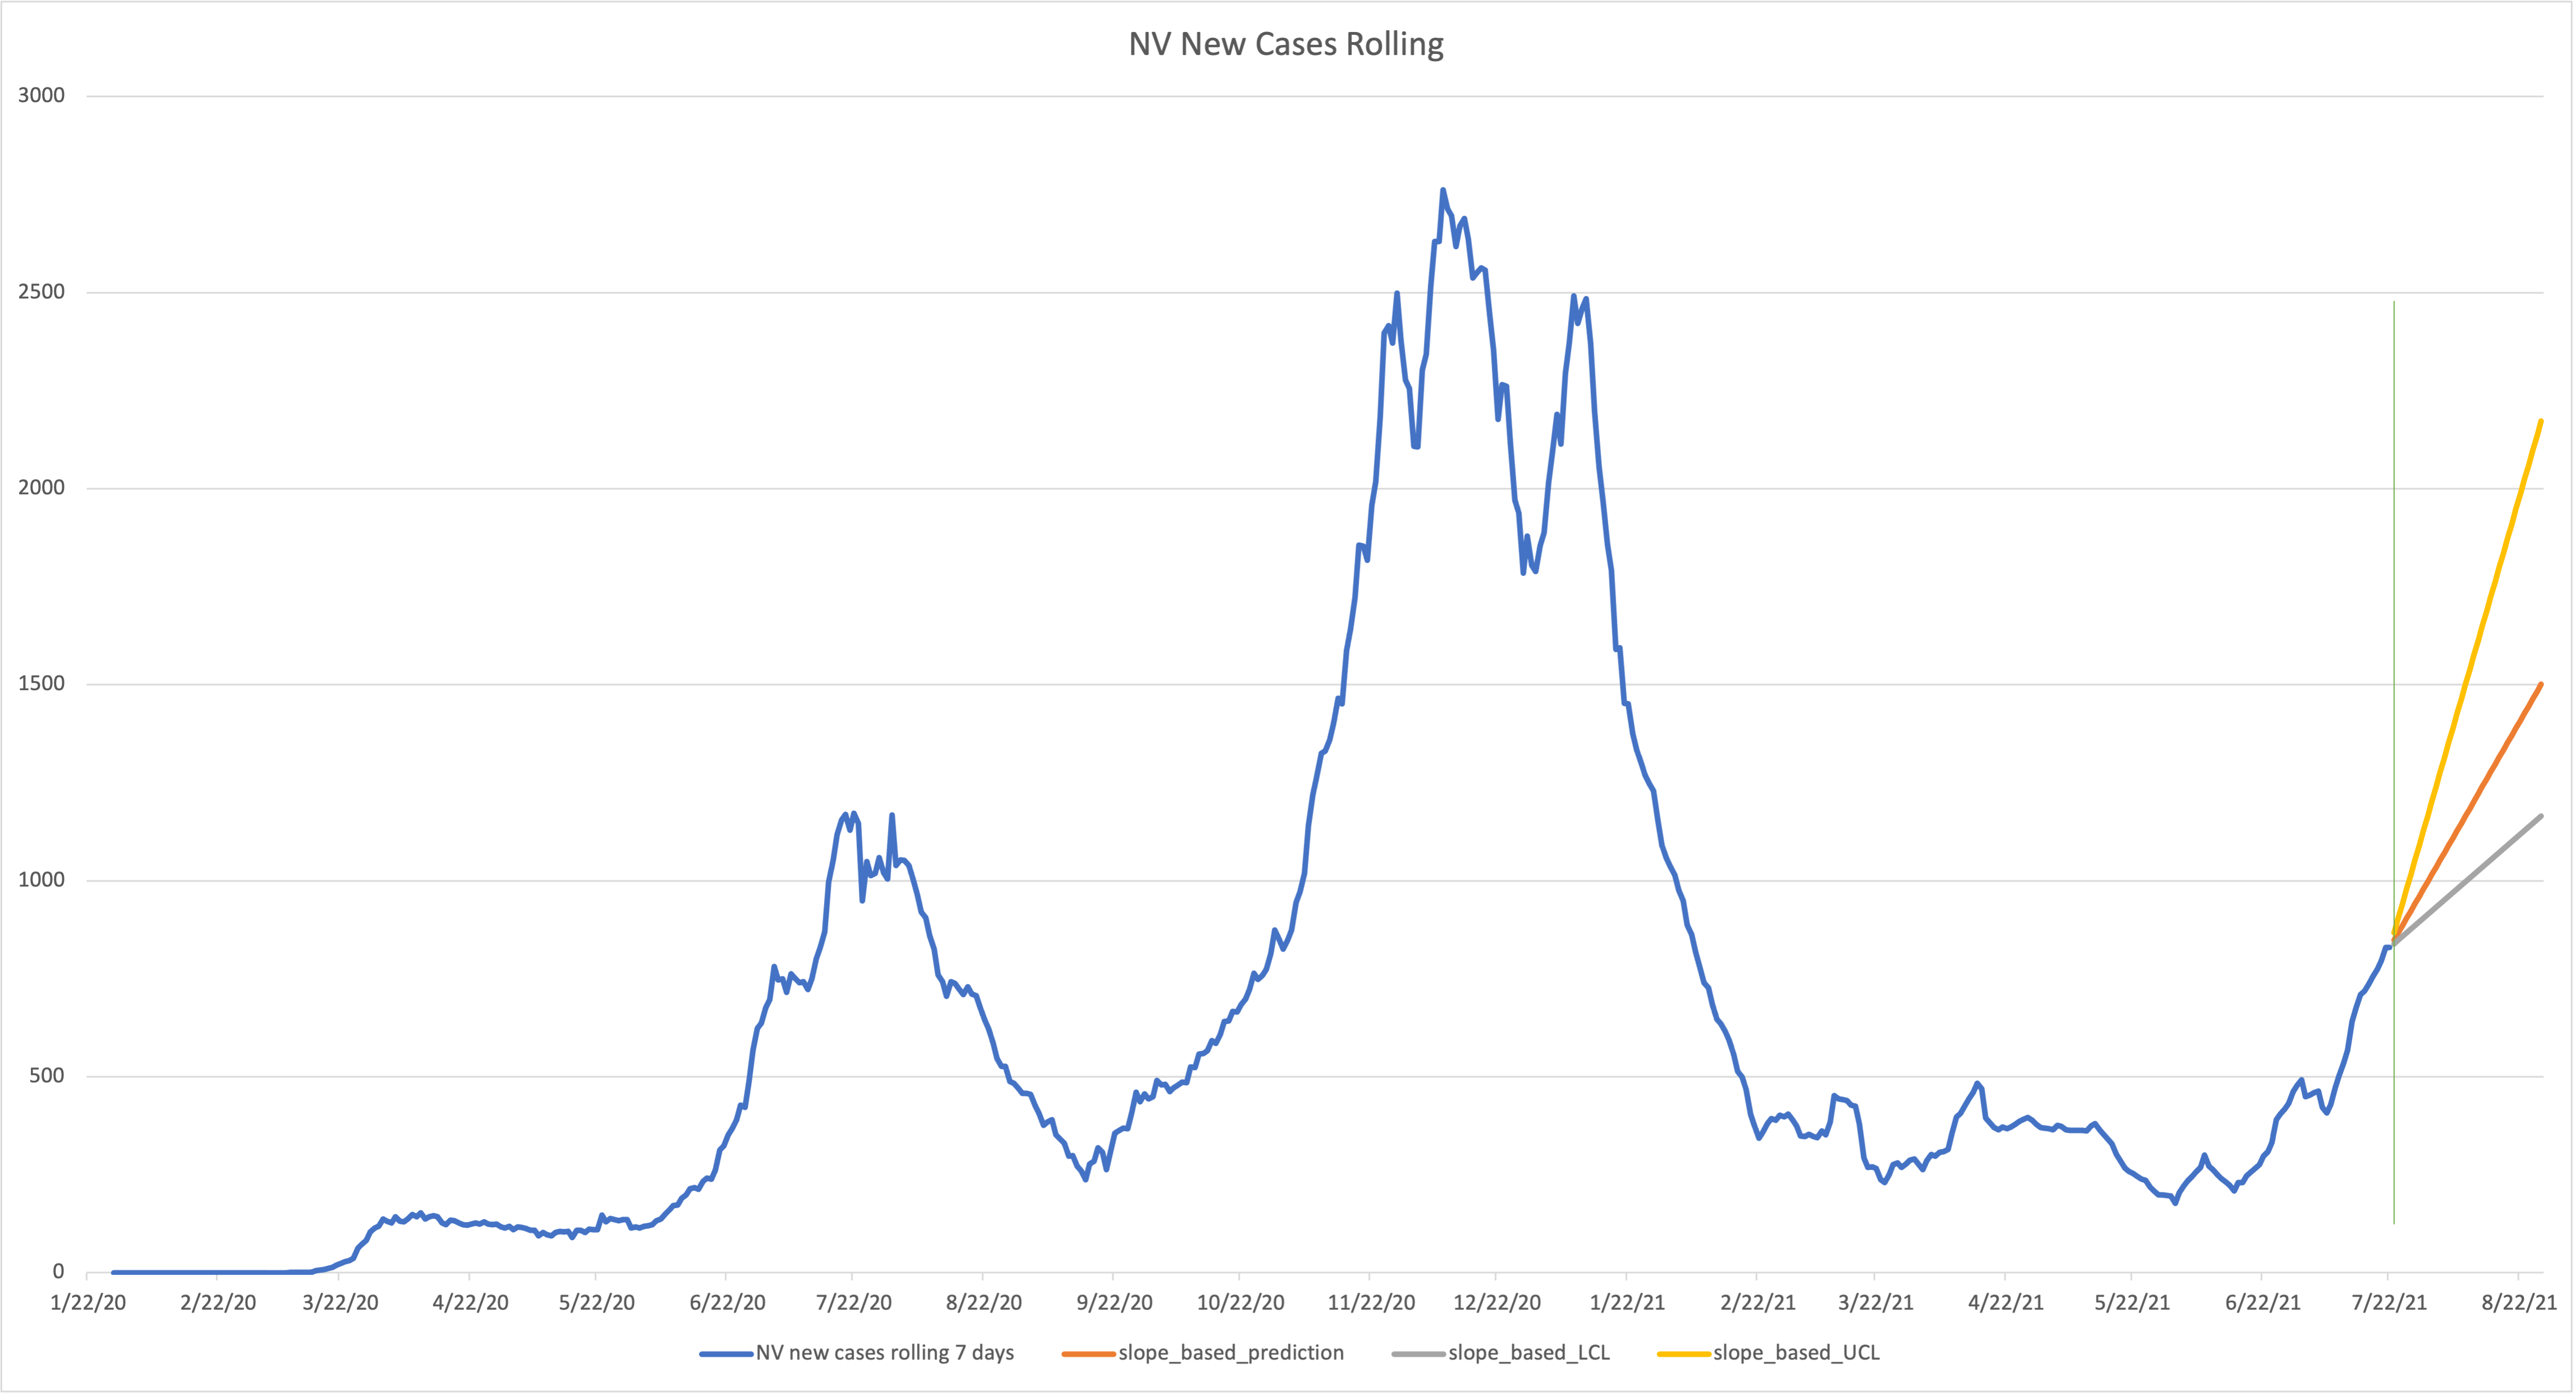

In [60]:
image(f('./data2/NV Slope Based 1.png'))

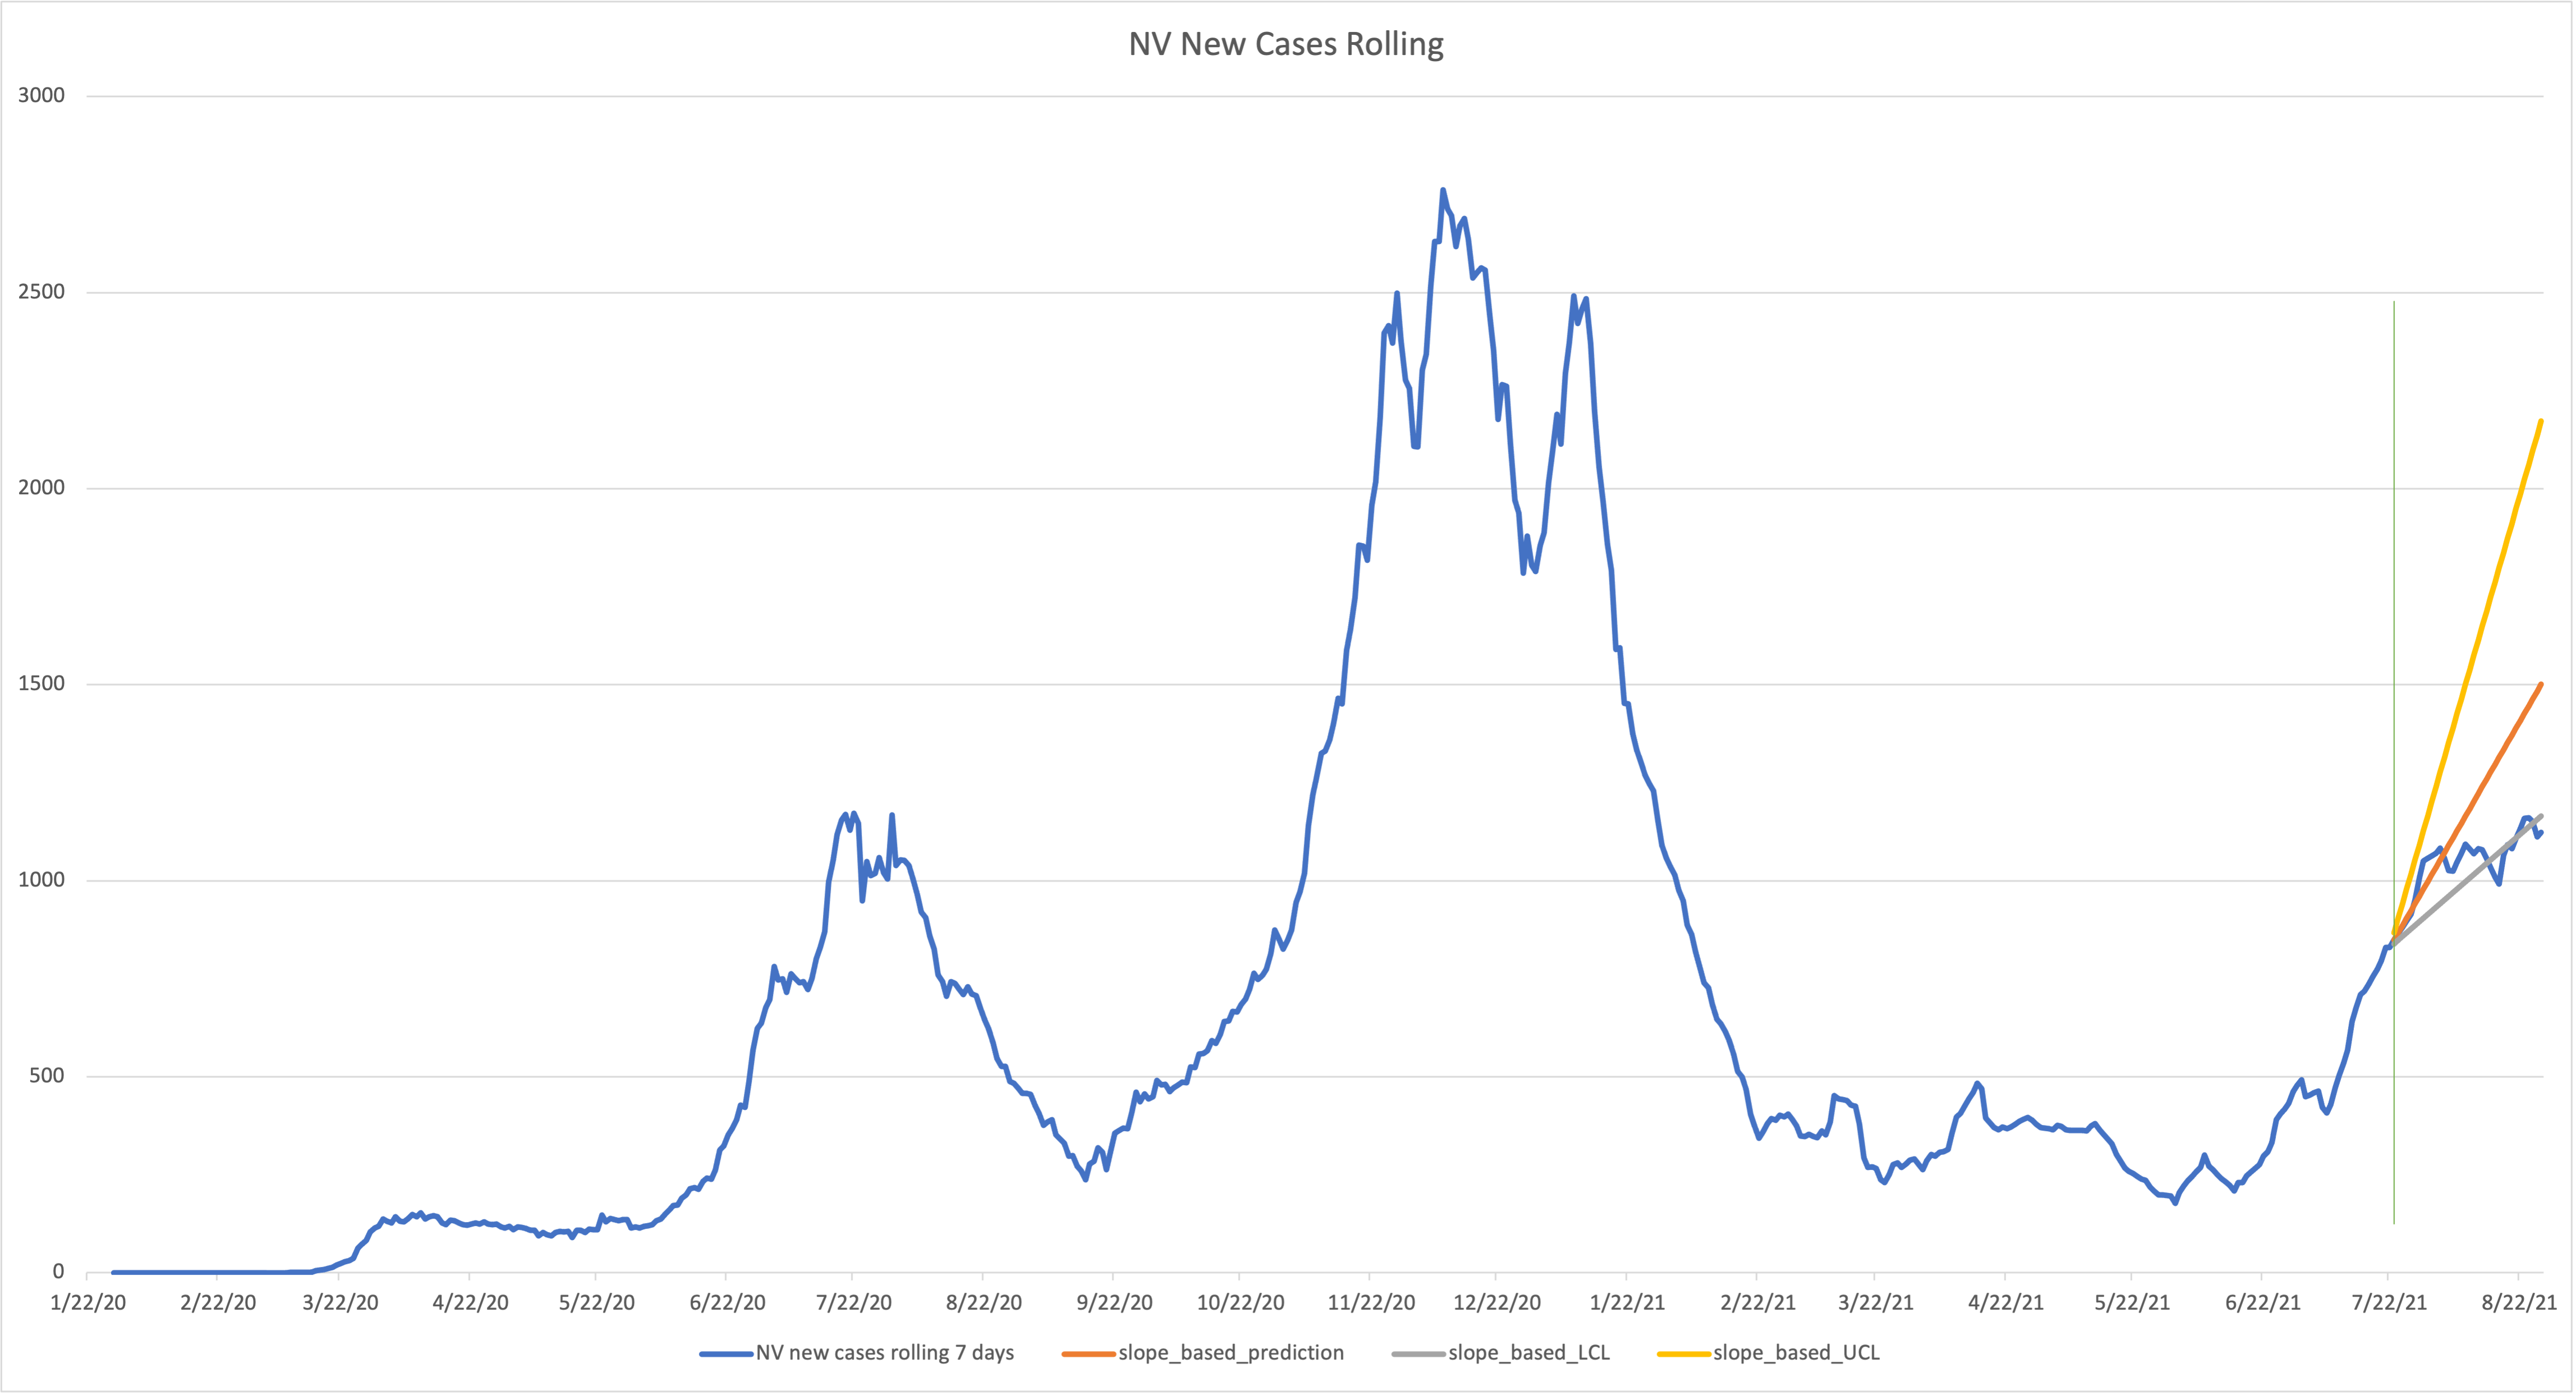

In [61]:
image(f('./data2/NV Slope Based 2.png'))

In [62]:
show_anomaly_pivot('anomaly_by_slope') # search by slope

In [63]:
# ok We can search for anomalies by rule (time consuming), by mean (not bad, typical), 
# by slope 
# (takes more into account), but what about other patterns - seasonality (hourly, weekly), 
# cyclical (sine waves)
# increasing but cyclical, and on and on.  

# why not use the most sophisticated prediction method available right now - machine learning
# Go into NASA analogy.  

In [64]:
# Baseline a few non-ML models
# 1. predict just the mean

In [65]:
def myMAPE(y_true, y_pred):
    # this way of writing it can deal with zeros.
    df = pd.DataFrame()
    df['y_true'] = y_true
    df['y_pred'] = y_pred
    df = df[~(df['y_true'] == 0)] # discarding % errors to zero
    df['error'] = df['y_true'] - df['y_pred']
    df['abs_error'] = df['error'].abs()
    df['percent_error'] = df['abs_error'] / df['y_true']
    mean = df['percent_error'].mean()
    return mean
    

In [66]:
mean_absolute_error(test['new_case_rolling_7_days'], test['state_median']) 
# 1287 average error
# test[['new_case_rolling_7_days', 'state_median']].to_csv('temp_4Sep2021.csv')

1286.988229755179

In [67]:
# 2 non-ML model.  Use the slope_based_prediction
mean_absolute_error(test['new_case_rolling_7_days'], test['slope_based_prediction'])
# 467
# test[test['state'] == 'MA'][['new_case_rolling_7_days', 
#                             'slope_based_prediction']].to_csv('temp_4Sep2021.csv')

467.4475047080979

In [68]:
# now some ML

In [69]:
NUM_LAGS = 10
def add_lags(df, label):
    for window in range(1, NUM_LAGS):
        df[f'label_{window}_day_lag'] = df.groupby(
            'state')[label].transform(lambda x:x.shift(window))
    return df

class TimeSeriesPipeline:
    
    def __init__(self):
        self.prior_predictions = pd.DataFrame()
        
    def fit(self, df):
        pass
    
    def transform_train(self, df):
        df = add_lags(df, 'new_case_rolling_7_days')
        df.dropna(subset=['new_case_rolling_7_days'], inplace=True)
        self.prior_dates = df.copy()
        self.prior_dates['rolling_target'] = self.prior_dates['new_case_rolling_7_days']
        return df
    
    def transform_test(self, df):
            
        assert df['submission_date'].nunique() == 1
        date = df['submission_date'].unique()[0]
        df['new_case_rolling_7_days'] = np.nan # ensure label isn't mixed in
        all_df = self.prior_dates.append(self.prior_predictions)
        all_df = all_df.append(df)
        all_df = add_lags(all_df, 'rolling_target')
        # all_df[all_df['state'] == 'MA'][['submission_date', 'new_case_rolling_7_days', 'rolling_target']]
        test_df = all_df[all_df['submission_date'] == date]
        cols = [f'label_{c}_day_lag' for c in range(1, NUM_LAGS)]
        test_df = test_df[list(df.columns) + cols]
        return test_df
    
    def register_prediction(self, df):
        self.prior_predictions = self.prior_predictions.append(
            df.rename(columns={'ypred': "rolling_target"}))

In [70]:
train.columns

Index(['submission_date', 'tot_cases', 'conf_cases', 'prob_cases', 'new_case',
       'pnew_case', 'tot_death', 'conf_death', 'prob_death', 'new_death',
       'pnew_death', 'state', 'Population', 'new_case_rolling_7_days',
       'submission_date_day_of_year', 'submission_date_month',
       'submission_date_day_of_week', 'submission_date_year', 'state_encoded',
       'state_mean', 'state_std', 'state_median', 'state_10%_percentile',
       'state_90%_percentile', 'anomaly_by_rule', 'anomaly_by_mean',
       'new_case_rolling_lagged', 'new_case_slope', 'slope_based_prediction',
       'slope_based_LCL', 'slope_based_UCL', 'anomaly_by_slope'],
      dtype='object')

In [71]:
myTSPipline = TimeSeriesPipeline()

In [72]:
myTSPipline.fit(train)

In [73]:
train = myTSPipline.transform_train(train)

In [74]:
feature_cols = ['submission_date_day_of_year', 'submission_date_month',
                'submission_date_day_of_week', 'submission_date_year', 'state_encoded']
for lag in range(1, NUM_LAGS):
    col = f'label_{lag}_day_lag'
    feature_cols.append(col)
train[feature_cols]

submission_date_day_of_year  submission_date_month  \
354                             28                      1   
355                             28                      1   
356                             28                      1   
357                             28                      1   
358                             28                      1   
...                            ...                    ...   
32327                          203                      7   
32328                          203                      7   
32329                          203                      7   
32330                          203                      7   
32331                          203                      7   

       submission_date_day_of_week  submission_date_year  state_encoded  \
354                              1                  2020              9   
355                              1                  2020             25   
356                              1                  2020              2   
357                              1                  2020             16   
358                              1                  2020             54   
...                            ...                   ...            ...   
32327                            3                  2021             38   
32328                            3                  2021             41   
32329                            3                  2021             29   
32330                            3                  2021             12   
32331                            3                  2021             55   

       label_1_day_lag  label_2_day_lag  label_3_day_lag  label_4_day_lag  \
354                NaN              NaN              NaN              NaN   
355                NaN              NaN              NaN              NaN   
356                NaN              NaN              NaN              NaN   
357                NaN              NaN              NaN              NaN   
358                NaN              NaN              NaN              NaN   
...                ...              ...              ...              ...   
32327        17.571429        12.142857        13.571429        12.571429   
32328       717.142857       680.428571       734.000000       683.285714   
32329       254.142857       223.285714       186.857143       182.857143   
32330        90.714286        82.000000        78.857143        74.857143   
32331        93.857143        86.428571        81.571429        80.714286   

       label_5_day_lag  label_6_day_lag  label_7_day_lag  label_8_day_lag  \
354                NaN              NaN              NaN              NaN   
355                NaN              NaN              NaN              NaN   
356                NaN              NaN              NaN              NaN   
357                NaN              NaN              NaN              NaN   
358                NaN              NaN              NaN              NaN   
...                ...              ...              ...              ...   
32327        11.857143        11.142857        10.428571        10.428571   
32328       632.714286       707.142857       665.142857       635.571429   
32329       178.714286       174.571429       163.571429       165.285714   
32330        70.857143        66.857143        63.428571        59.571429   
32331        80.142857        79.571429        84.285714        84.857143   

       label_9_day_lag  
354                NaN  
355                NaN  
356                NaN  
357                NaN  
358                NaN  
...                ...  
32327         9.714286  
32328       592.714286  
32329       161.714286  
32330        58.000000  
32331        84.714286  

[31978 rows x 14 columns]

In [75]:
param = {
    'objective':'reg:squarederror', 
    'verbosity': 1 }

In [76]:
# determine number of boosting rounds via an eval set
# assumes train has 'submission_date and 'target'
def calc_best_iteration(train, feature_cols, param):
    assert 'submission_date' in train
    assert 'target' in train
    total_dates = train['submission_date'].nunique()
    eval_date = sorted(train['submission_date'].unique())[-int(total_dates * 0.2)]
    eval_mask = train['submission_date'] >= eval_date
    dtrain = xgb.DMatrix(train[~eval_mask][feature_cols], label=train[~eval_mask]['target'])
    dvalid = xgb.DMatrix(train[eval_mask][feature_cols], label=train[eval_mask]['target'])
    (dtrain.num_row(), dtrain.num_col()), (dvalid.num_row(), dvalid.num_col()) 
    evallist = [(dtrain, 'train'), (dvalid, 'valid')]
    bst = xgb.train(param, dtrain, 1000, evallist, 
                    early_stopping_rounds=10, 
                    verbose_eval=100)
    return bst.best_iteration

In [77]:
num_boost_round = calc_best_iteration(
    train.rename(columns={"new_case_rolling_7_days": "target"}), feature_cols, param)
num_boost_round

[0]	train-rmse:2077.42798	valid-rmse:777.92364
[27]	train-rmse:71.46317	valid-rmse:61.32852


18

In [78]:
# now we'll train on all data (without an eval set) using that number of boosting
# rounds. This is the way I like to do it but others may disagree. 

dtrain = xgb.DMatrix(train[feature_cols], label=train['new_case_rolling_7_days'])
dtrain.num_row(), dtrain.num_col()

(31978, 14)

In [79]:
evallist = [(dtrain, 'train')]

In [80]:
bst = xgb.train(param, dtrain, num_boost_round, evallist, 
#                 early_stopping_rounds=10, 
                verbose_eval=100)

[0]	train-rmse:1891.06494
[17]	train-rmse:77.85892


In [81]:
test.columns

Index(['index', 'submission_date', 'tot_cases', 'conf_cases', 'prob_cases',
       'new_case', 'pnew_case', 'tot_death', 'conf_death', 'prob_death',
       'new_death', 'pnew_death', 'state', 'Population',
       'new_case_rolling_7_days', 'submission_date_day_of_year',
       'submission_date_month', 'submission_date_day_of_week',
       'submission_date_year', 'state_encoded', 'state_mean', 'state_std',
       'state_median', 'state_10%_percentile', 'state_90%_percentile',
       'anomaly_by_rule', 'new_case_z_score', 'anomaly_by_mean',
       'prediction_tuple', 'slope_based_prediction', 'slope_based_LCL',
       'slope_based_UCL', 'anomaly_by_slope'],
      dtype='object')

In [82]:
# running this test set kaggle-style - one day at a time. I am experimenting with using
# predictions as the lags for future predictions, which is often the way kaggle competitions
# work because either they want you to predict the entire test set without giving you any
# hints or you just submit your code and the test will actually be in the future as they
# will run your code on dates that occur after the submission deadline to determine the actual
# winner.

test_dates = sorted(test['submission_date'].unique())
predictions = pd.DataFrame()
test_with_features = pd.DataFrame()
for date in test_dates:
    print(date, end=", ", flush=True)
    test_one_date = test[test['submission_date'] == date].copy()
    test_one_date = myTSPipline.transform_test(test_one_date)
    dtest = xgb.DMatrix(test_one_date[feature_cols])
    ypred = bst.predict(dtest, ntree_limit=bst.best_iteration).clip(0)
    this_prediction = test_one_date.copy()
    this_prediction['ypred'] = ypred
    predictions = predictions.append(this_prediction)

    # this is a little confusing.  
    # if you want to predict the entire test set without using any actuals, like a kaggle competition,
    # then PREDICT_WITH_ACTUALS = False
    # if you like to use yesterday's actuals as input (like in the real world), then you would make
    # PREDICT_WITH_ACTUALS = True
    
    if PREDICT_WITH_ACTUALS:
        test_one_date['ypred'] = test.loc[test_one_date.index]['new_case_rolling_7_days']
    else:
        pdb.set_trace() # watch this once.
        test_one_date['ypred'] = ypred
        
    myTSPipline.register_prediction(test_one_date)

    test_with_features = test_with_features.append(test_one_date)

2021-07-23, 2021-07-24, 2021-07-25, 2021-07-26, 2021-07-27, 2021-07-28, 2021-07-29, 2021-07-30, 2021-07-31, 2021-08-01, 2021-08-02, 2021-08-03, 2021-08-04, 2021-08-05, 2021-08-06, 2021-08-07, 2021-08-08, 2021-08-09, 2021-08-10, 2021-08-11, 2021-08-12, 2021-08-13, 2021-08-14, 2021-08-15, 2021-08-16, 2021-08-17, 2021-08-18, 2021-08-19, 2021-08-20, 2021-08-21, 2021-08-22, 2021-08-23, 2021-08-24, 2021-08-25, 2021-08-26, 2021-08-27, 

In [83]:
predictions.columns

Index(['index', 'submission_date', 'tot_cases', 'conf_cases', 'prob_cases',
       'new_case', 'pnew_case', 'tot_death', 'conf_death', 'prob_death',
       'new_death', 'pnew_death', 'state', 'Population',
       'new_case_rolling_7_days', 'submission_date_day_of_year',
       'submission_date_month', 'submission_date_day_of_week',
       'submission_date_year', 'state_encoded', 'state_mean', 'state_std',
       'state_median', 'state_10%_percentile', 'state_90%_percentile',
       'anomaly_by_rule', 'new_case_z_score', 'anomaly_by_mean',
       'prediction_tuple', 'slope_based_prediction', 'slope_based_LCL',
       'slope_based_UCL', 'anomaly_by_slope', 'label_1_day_lag',
       'label_2_day_lag', 'label_3_day_lag', 'label_4_day_lag',
       'label_5_day_lag', 'label_6_day_lag', 'label_7_day_lag',
       'label_8_day_lag', 'label_9_day_lag', 'ypred'],
      dtype='object')

In [84]:
test = test.merge(
    predictions[['submission_date', 'state', 'ypred']], on=['submission_date', 'state'], how='left')

In [85]:
test[['submission_date', 'state', 'new_case_rolling_7_days', 'ypred']]

submission_date state  new_case_rolling_7_days        ypred
0         2021-07-23    AK               185.428571   174.293350
1         2021-07-23    AL              1551.000000  1504.676880
2         2021-07-23    AR              1390.428571  1326.836914
3         2021-07-23    AS                 0.000000     1.937997
4         2021-07-23    AZ              1145.142857  1136.473999
...              ...   ...                      ...          ...
2119      2021-08-27    VT                98.857143   112.739426
2120      2021-08-27    WA              3219.285714  3090.306885
2121      2021-08-27    WI              1821.857143  1718.167847
2122      2021-08-27    WV              1021.285714   977.313477
2123      2021-08-27    WY               399.428571   401.365356

[2124 rows x 4 columns]

In [86]:
mean_absolute_error(test['new_case_rolling_7_days'], test['ypred']) 

64.91804814973698

In [87]:
save_state('MA', ['ypred'])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

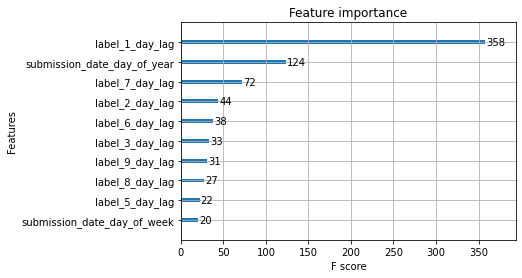

In [88]:
xgb.plot_importance(bst, max_num_features=10)

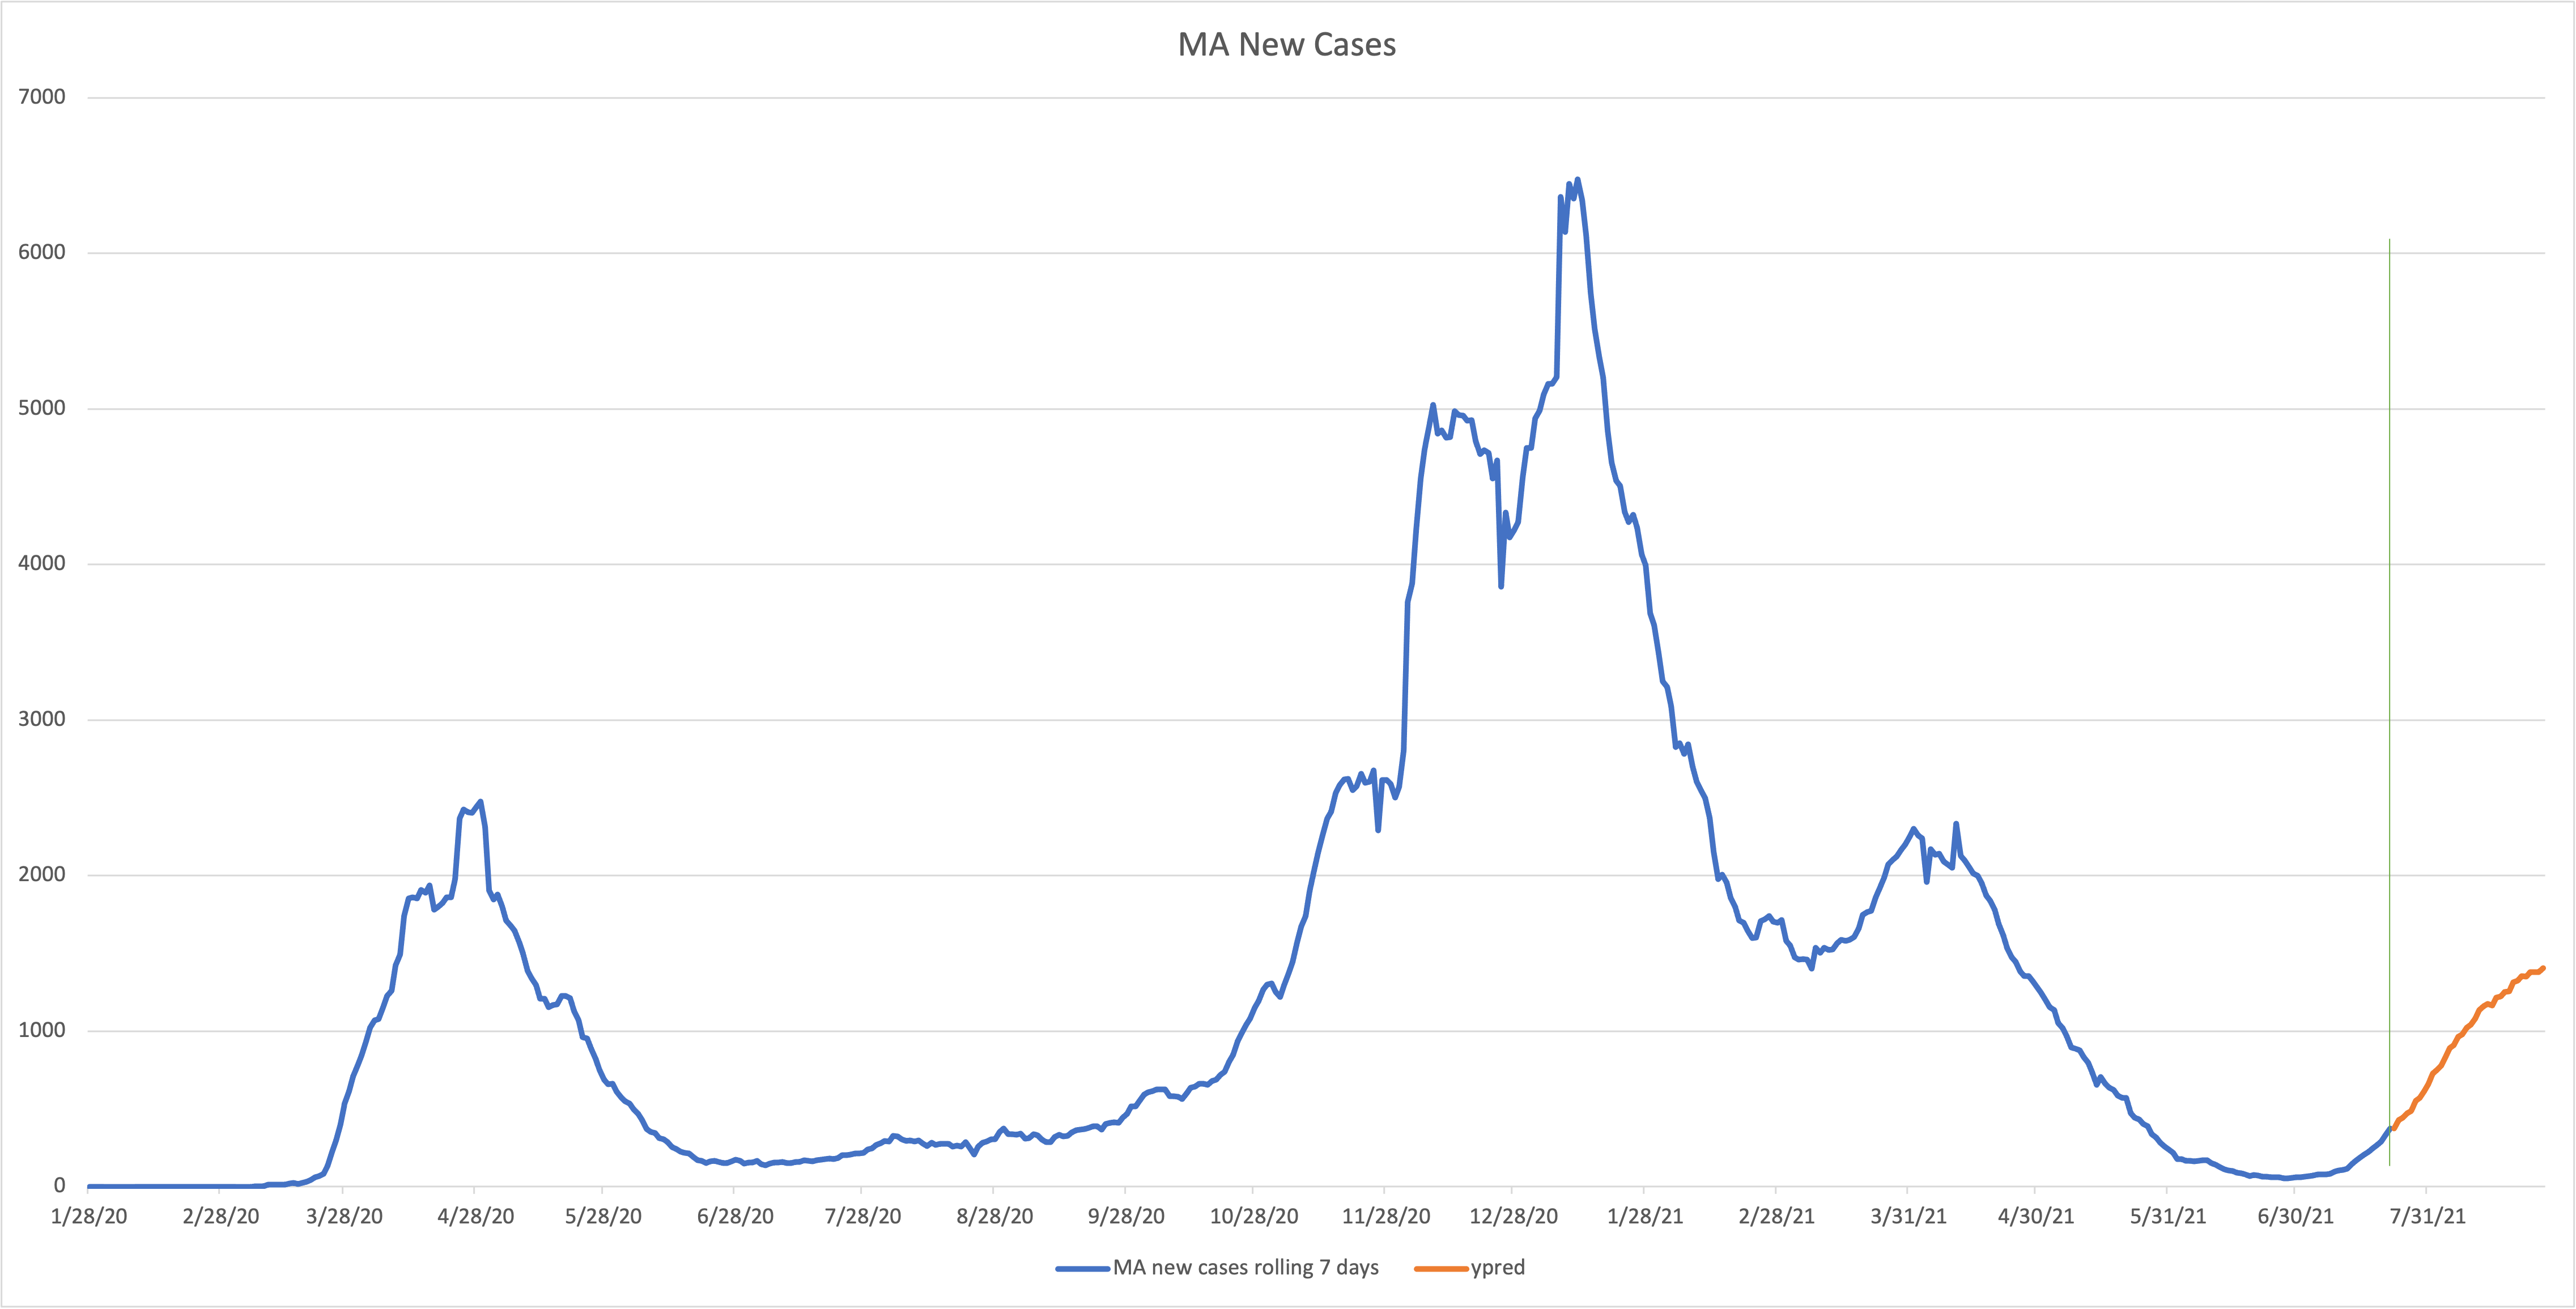

In [89]:
image(f("./data2/MA_ML_1.png"))

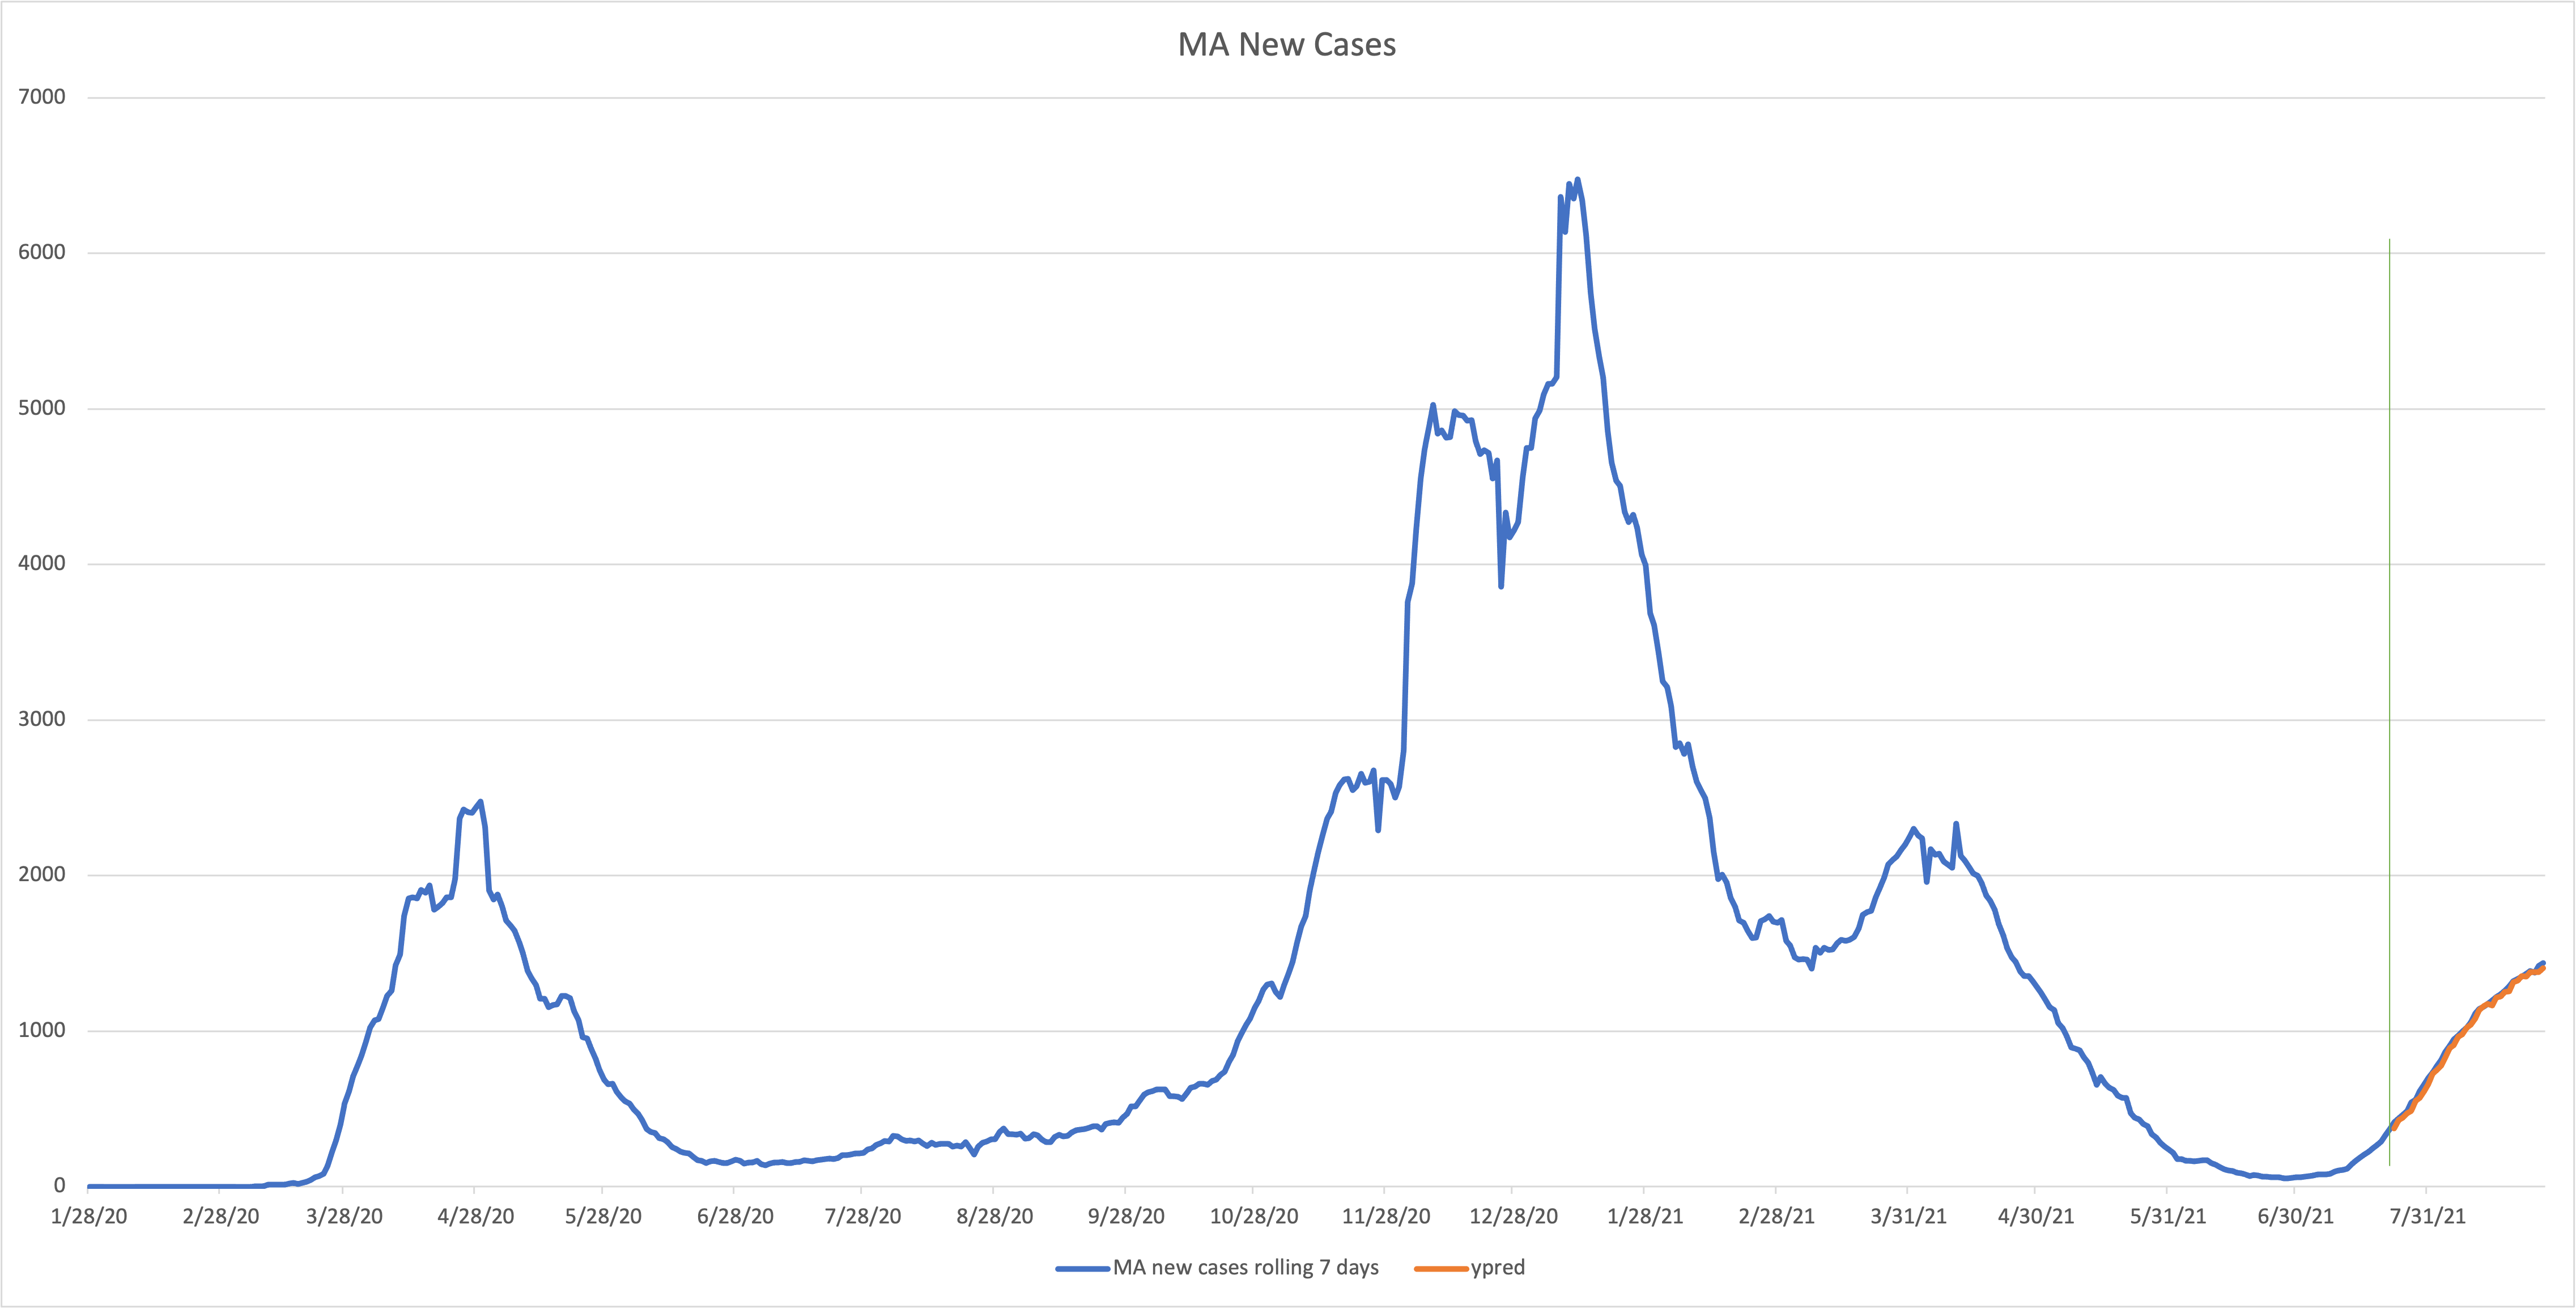

In [90]:
image(f("./data2/MA_ML_2.png"))

In [91]:
test.columns

Index(['index', 'submission_date', 'tot_cases', 'conf_cases', 'prob_cases',
       'new_case', 'pnew_case', 'tot_death', 'conf_death', 'prob_death',
       'new_death', 'pnew_death', 'state', 'Population',
       'new_case_rolling_7_days', 'submission_date_day_of_year',
       'submission_date_month', 'submission_date_day_of_week',
       'submission_date_year', 'state_encoded', 'state_mean', 'state_std',
       'state_median', 'state_10%_percentile', 'state_90%_percentile',
       'anomaly_by_rule', 'new_case_z_score', 'anomaly_by_mean',
       'prediction_tuple', 'slope_based_prediction', 'slope_based_LCL',
       'slope_based_UCL', 'anomaly_by_slope', 'ypred'],
      dtype='object')

In [92]:
error_stats = (test['new_case_rolling_7_days'] - test['ypred']).describe()
mean, std = error_stats['mean'], error_stats['std']
lcl = mean - (2 * std)
ucl = mean + (2 * std)
lcl, ucl

(-333.14469268751185, 407.74150566825193)

In [93]:
error_series = (test['new_case_rolling_7_days'] - test['ypred'])
test['anomaly_by_ml'] = ((error_series < lcl) | (error_series > ucl))

In [94]:
show_anomaly_pivot('anomaly_by_ml')

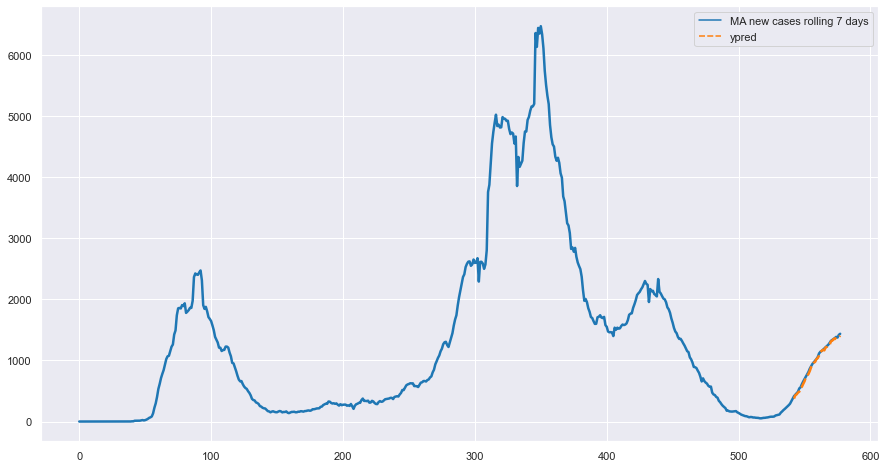

In [95]:

sns.set_theme(style="whitegrid")
df = pd.read_csv('MA_new_cases_rolling.csv')
# df.dropna(inplace=True)
dates = df['submission_date']
values = df[['MA new cases rolling 7 days', 'ypred']]

sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=values, palette="tab10", linewidth=2.5)
values.to_csv('temp_9Sep2021.csv', index=False)

In [96]:
values

MA new cases rolling 7 days        ypred
0                       0.000000          NaN
1                       0.000000          NaN
2                       0.000000          NaN
3                       0.000000          NaN
4                       0.142857          NaN
..                           ...          ...
573                  1367.714286  1350.954834
574                  1386.571429  1380.286255
575                  1374.571429  1380.286255
576                  1419.571429  1380.286255
577                  1437.142857  1406.367432

[578 rows x 2 columns]

In [97]:
save_state('TX', ['ypred', 'anomaly_by_ml'])

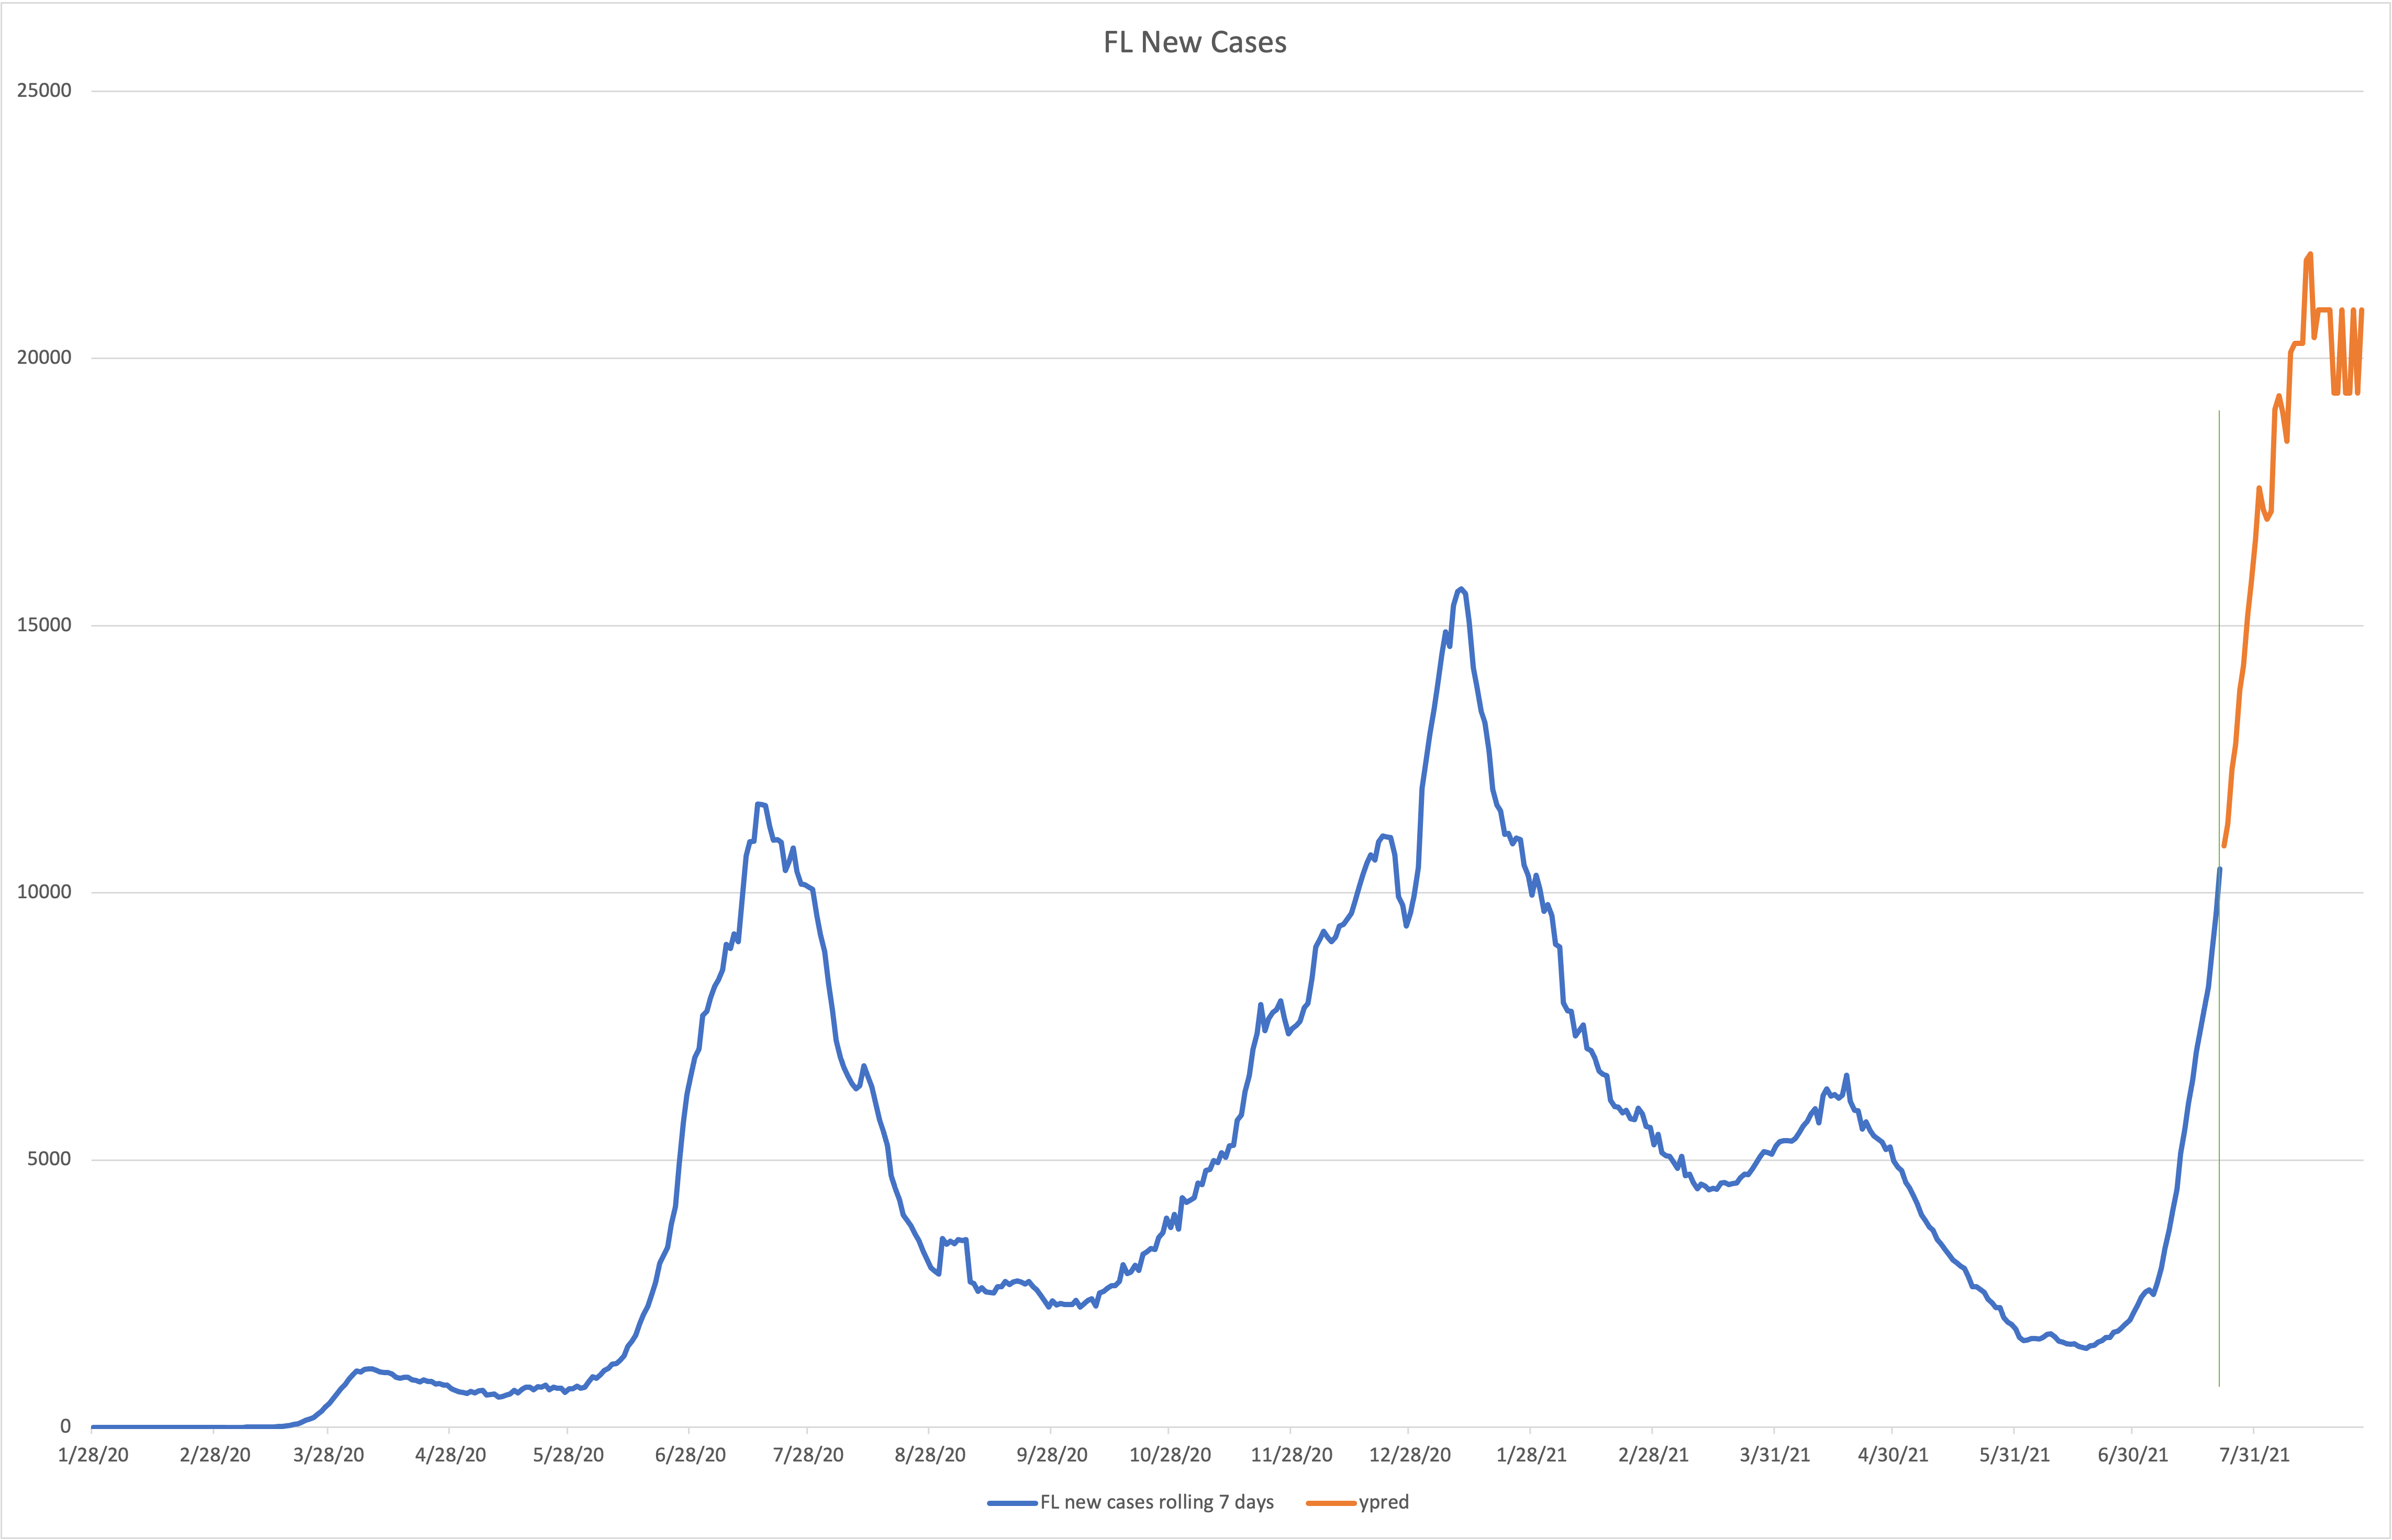

In [98]:
image(f("./data2/FL_ML_1.png"))

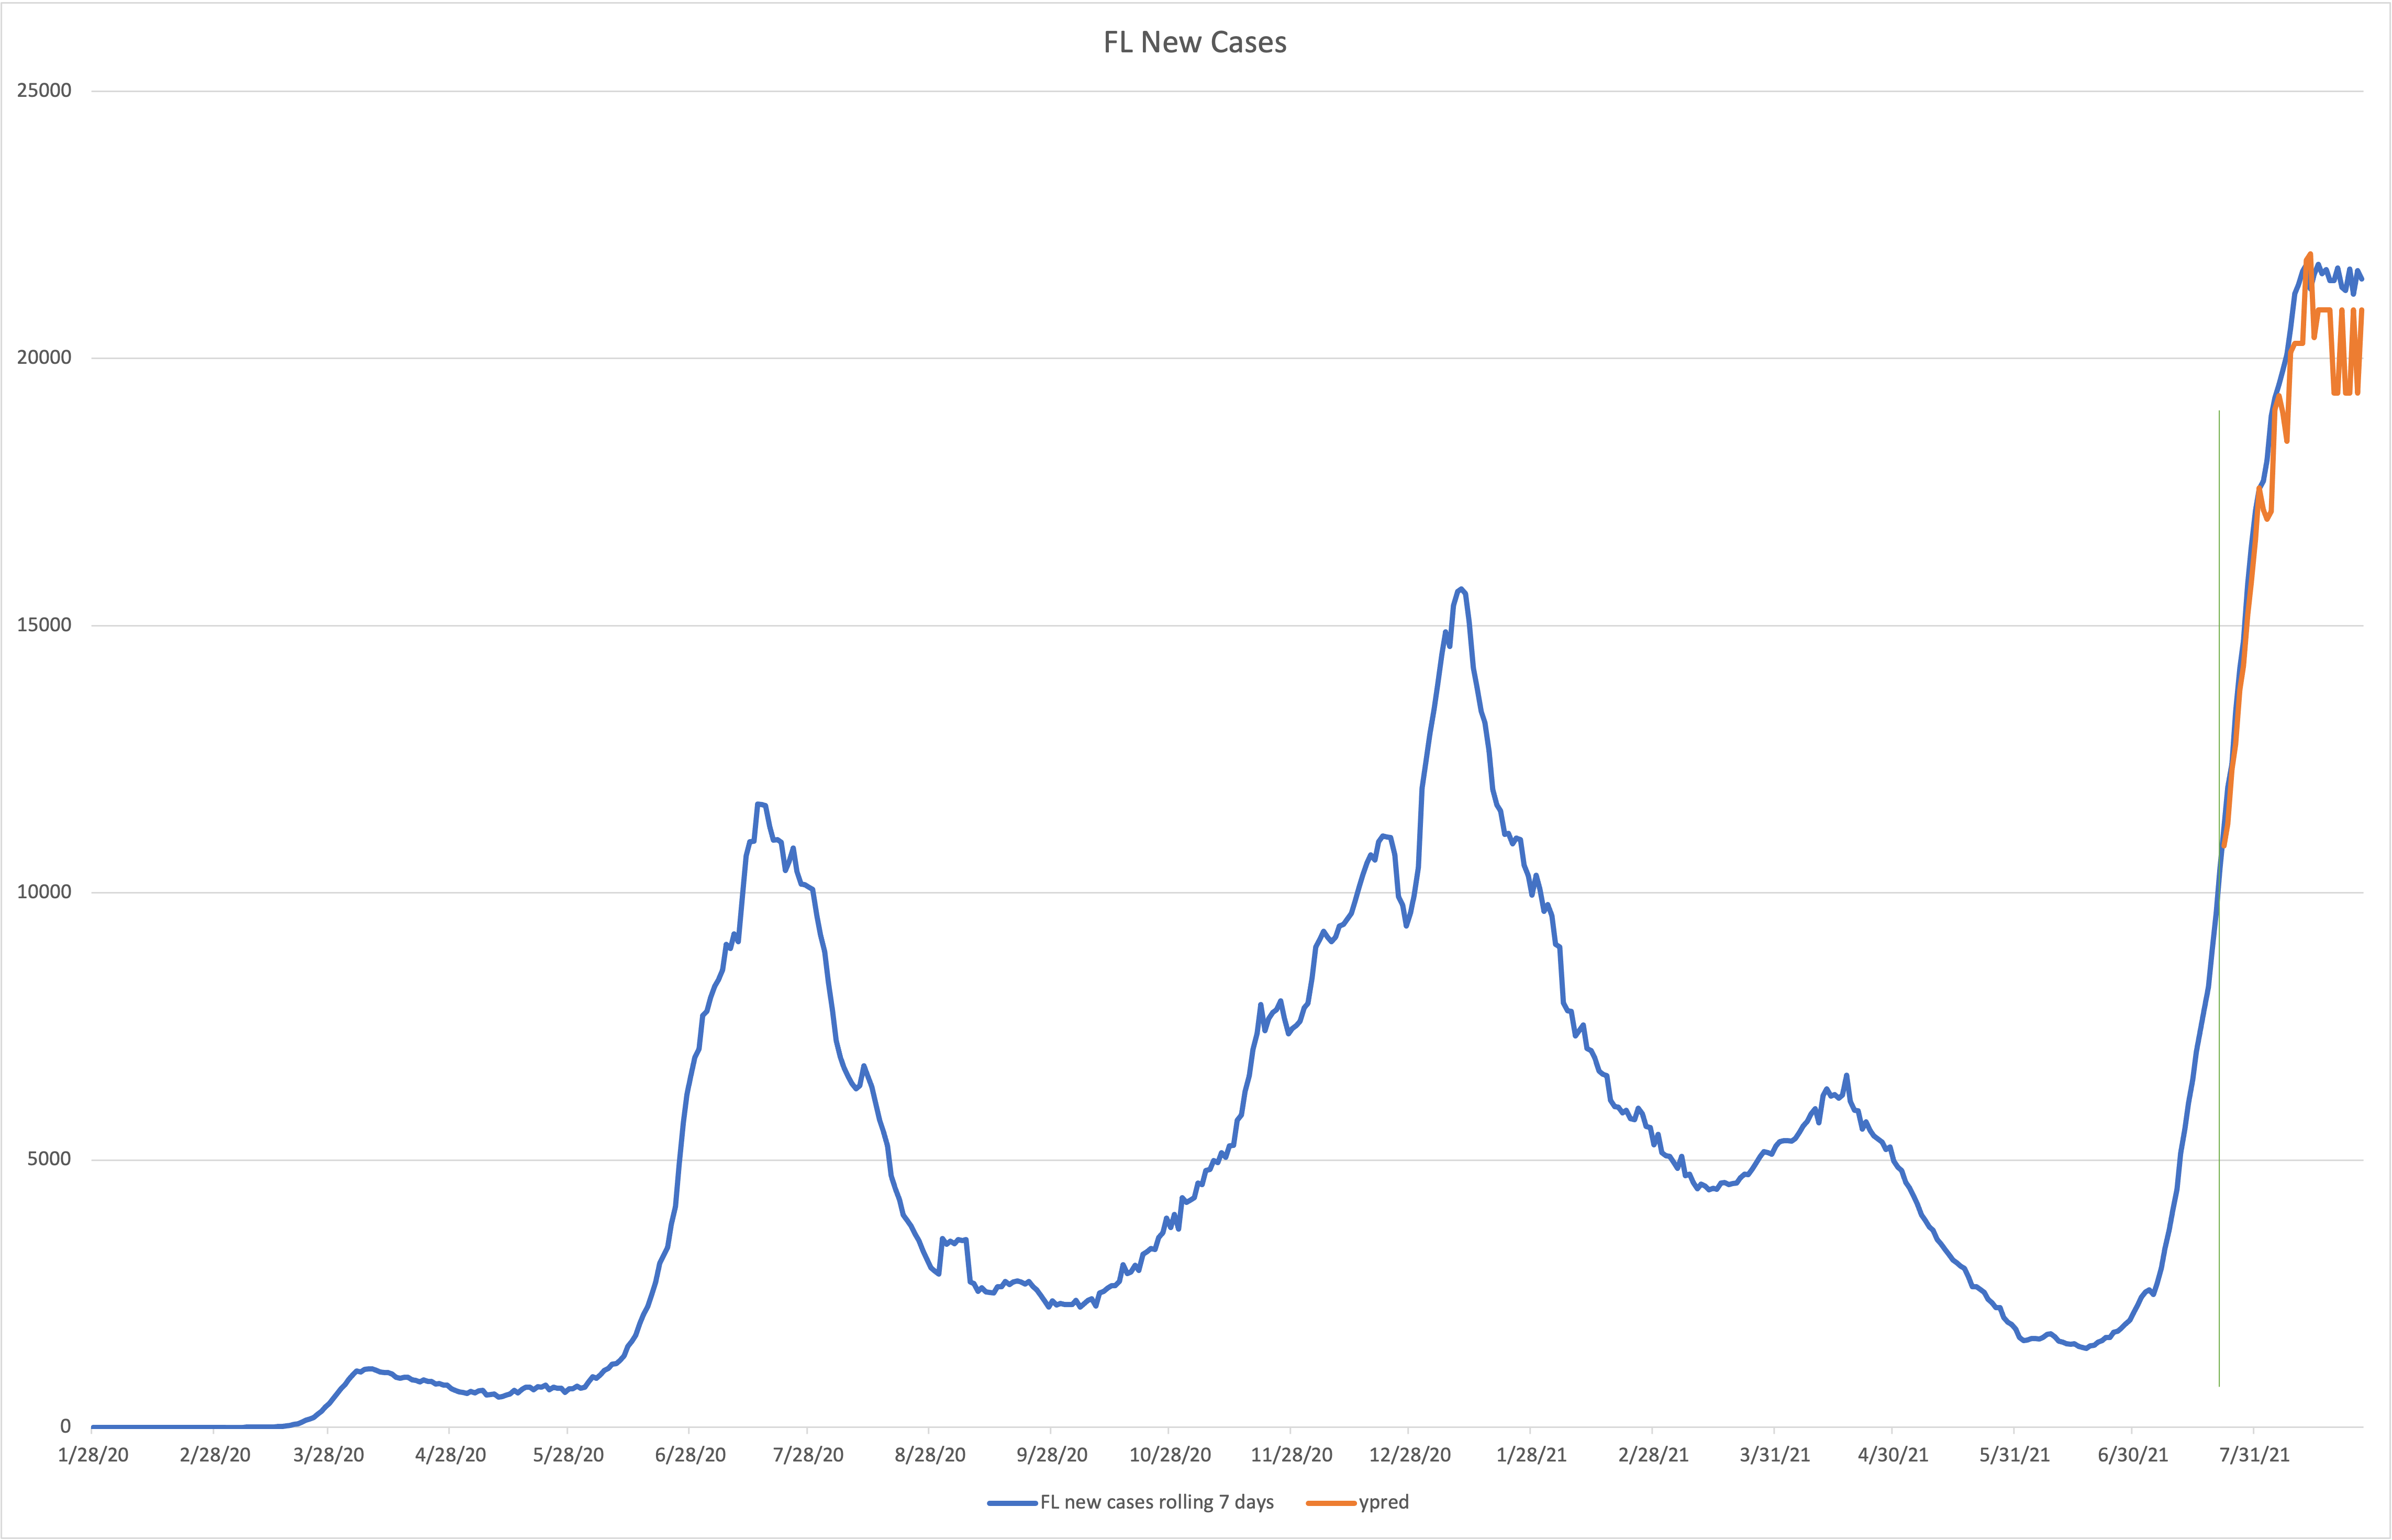

In [99]:
image(f("./data2/FL_ML_2.png"))

In [100]:
# ok - let's look at some other time series data

In [101]:
# prepare the data so that the below works fine.
def original_df():
    data_path = f(
        './data2/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
    df = pd.read_csv(data_path, parse_dates=['submission_date'])
    return df
df = original_df()
df.rename(columns={"submission_date": "date", "state": "entity"}, inplace=True)

# change new_case to rolling new_cases
df.sort_values(['date', 'entity'], inplace=True)
df_rolling = df[['entity', 'new_case']].groupby('entity')['new_case'].rolling(7).mean()
df_rolling.index = df_rolling.index.droplevel()
df['new_case'] = df_rolling
df.dropna(subset=['new_case'], inplace=True)

# save it
path = Path('covid-new-cases.csv')
df[['date', 'entity', 'new_case']].to_csv(path, index=False)
df[['date', 'entity', 'new_case']]

date entity     new_case
32120 2020-01-28     AK     0.000000
9013  2020-01-28     AL     5.571429
29719 2020-01-28     AR     0.000000
4168  2020-01-28     AS     0.000000
26951 2020-01-28     AZ     0.142857
...          ...    ...          ...
13751 2021-08-27     VT    98.857143
23229 2021-08-27     WA  3219.285714
19432 2021-08-27     WI  1821.857143
4319  2021-08-27     WV  1021.285714
24327 2021-08-27     WY   399.428571

[34680 rows x 3 columns]

In [102]:
# prepare S&P data
df = pd.read_csv(f('./data2/DownloadData-INDEX_US_S&P_US_SPX.csv'), parse_dates=['Date'], 
                 thousands=',')
df.rename(columns={"Date": "date"}, inplace=True)
df['entity'] = "S&P"
df[['date', 'entity', 'Close']].to_csv('S&P-data.csv', index=False)
df.dtypes

date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
entity            object
dtype: object

In [103]:
# prepare daily temp data
df = pd.read_csv(f('./data2/daily-min-temperatures.csv'), parse_dates=['Date'])
df.rename(columns={"Date": "date"}, inplace=True)
df['entity'] = "Melbourne"
df.to_csv('daily-min-temps2.csv', index=False)
df

date  Temp     entity
0    1981-01-01  20.7  Melbourne
1    1981-01-02  17.9  Melbourne
2    1981-01-03  18.8  Melbourne
3    1981-01-04  14.6  Melbourne
4    1981-01-05  15.8  Melbourne
...         ...   ...        ...
3645 1990-12-27  14.0  Melbourne
3646 1990-12-28  13.6  Melbourne
3647 1990-12-29  13.5  Melbourne
3648 1990-12-30  15.7  Melbourne
3649 1990-12-31  13.0  Melbourne

[3650 rows x 3 columns]

In [104]:
# prepare programming language dataset
df = pd.read_csv(f('./data2/programming-languages.csv'), skiprows=2, parse_dates=['Week'])
cols = [c.replace(": (United States)", "") for c in df.columns]
df.columns = cols
df = pd.melt(df, id_vars=['Week'], value_vars=['Python', 'JavaScript', 'Java', 'C', 'PHP'], 
        ignore_index=False)
df.rename(columns={"Week": "date", "value": "interest", "variable": "entity"}, inplace=True)
df.to_csv('programming-languages2.csv', index=False)
df['entity'].unique()

array(['Python', 'JavaScript', 'Java', 'C', 'PHP'], dtype=object)

In [105]:
# prep djia data
df = pd.read_csv(f('./data2/all_stocks_2006-01-01_to_2018-01-01.csv'), parse_dates=['Date'])
df['Date'].nunique() # 3020 dates / 250 = 12 years
df['Name'].nunique() # 31
df.rename(columns={"Date": "date", "Name": "entity", "Close": "price"}, inplace=True)
mask = df['date'] == '2010-04-01' # 24 stocks missing this date
df = df[~mask]
df = df.append( # MRK missing a price on one date
    pd.DataFrame({"date": [datetime(2009, 8, 11)], "entity": ["MRK"], "price": [30.67]}))
df.sort_values(['date', 'entity'], inplace=True)
df[['date', 'entity', 'price']].to_csv('djia.csv', index=False)
df[['date', 'entity', 'price']]

date entity   price
90593 2006-01-03   AABA   40.91
6040  2006-01-03   AAPL   10.68
87574 2006-01-03   AMZN   47.58
3020  2006-01-03    AXP   52.58
9059  2006-01-03     BA   70.44
...          ...    ...     ...
78514 2017-12-29    UNH  220.46
75494 2017-12-29    UTX  127.57
81534 2017-12-29     VZ   52.93
84554 2017-12-29    WMT   98.75
30197 2017-12-29    XOM   83.64

[93589 rows x 3 columns]

In [106]:
df = pd.read_csv(f('./data2/IrishWhiskeySalesbyVolume.csv'))
df.rename(columns={"Country": "entity"}, inplace=True)
def fn(year):
    return datetime(year, 1, 1)
df['date'] = df['Year'].apply(fn)
# df[['date', 'entity', 'Cases']].to_csv('whiskey.csv')
df.groupby(['date', 'entity'])['Cases'].sum().to_frame().to_csv('whiskey.csv')
df.groupby(['date', 'entity'])['Cases'].sum().to_frame()

Cases
date       entity                           
1990-01-01 Argentina                     0.0
           Australia                  9000.0
           Austria                    1250.0
           Belgium and Luxembourg     5000.0
           Brazil                        0.0
...                                      ...
2016-01-01 Switzerland               16250.0
           Thailand                  11500.0
           Ukraine                   56250.0
           United Kingdom           290250.0
           United States           3651255.0

[2052 rows x 1 columns]

In [107]:
# # prep NYC crime data
# df = pd.read_csv('./data2/NYPD_Complaint_Data_Current_YTD.csv')
# df['CMPLNT_FR_DT'].nunique() # 1517 dates
# df['ADDR_PCT_CD'].nunique() # 77 precincts
# df['date'] = pd.to_datetime(df['CMPLNT_FR_DT'], errors='coerce')
# df = df[df['date'].notnull()].copy() # get rid of junk dates
# # df.rename(columns={"ADDR_PCT_CD": "entity"}, inplace=True)
# df = df[df['ADDR_PCT_CD'].notnull()].copy() # get rid of blank precincts
# df['crimes'] = 1
# df2 = df.groupby(['date', 'ADDR_PCT_CD'])['crimes'].count()
# df2 = df2.to_frame().reset_index().rename(columns={"ADDR_PCT_CD": "entity"})



# # df2['date'].to_csv('temp_26Sep2021.csv')
# # sorted(df2['date'].unique(), reverse=True)
# # df['date'].unique()
# df2 = df2[df2['date'] >= '2015-01-01']
# df2['entity'] = df2['entity'].astype(int).astype(str)
# df2['entity'] = df2['entity'].str.pad(3,side='left', fillchar='0').apply(lambda s: "P-" + s)

# # change to rolling average
# df2.sort_values(['date', 'entity'], inplace=True)
# df_rolling = df2[['entity', 'crimes']].groupby('entity')['crimes'].rolling(7).mean()
# df_rolling.index = df_rolling.index.droplevel()
# df2['crimes2'] = df_rolling
# df2.dropna(subset=['crimes2'], inplace=True)
# df2.drop(columns=['crimes'], inplace=True)

# # fill in 0s if no crimes are listed for a precinct date combination
# df2.set_index(['date', 'entity'], inplace=True)
# date_df = df2.reset_index()[['date']].drop_duplicates() # all dates.
# entity_df = df2.reset_index()[['entity']].drop_duplicates() # all entities
# cross_df = date_df.merge(entity_df, how='cross') # cartesian product
# df2 = cross_df.set_index(['date', 'entity']).join(df2)
# df2.fillna(0, inplace=True)

# df2.to_csv('nyc_crime.csv', index=True)
# df2

In [108]:
# genericize my code such that I need three variables: 
# source_path: Path - where to fine the proper csv file. 
# entity_for_graphs: str - which entity I should show in the graphs
# dtype for pivot: type - whether to convert to ints for the pivot display.

# assumes a csv file containing the columns date, entity, and then one column which is the 
# metric (I'll add more later) in case some metrics are leading indicators of other metrics
# metric column must be number.
# each date, entity combination should only have one row of metrics.

In [109]:
# which ever one of these you'd like to run, just put that cell last.  or comment out 
# the others

# in the actual class I used covid, djia (stocks), and nyc crime

In [110]:
source_path = Path('daily-min-temps2.csv')
entity_for_graphs = 'Melbourne'
dtype_for_pivot = float

In [111]:
source_path = Path('whiskey.csv')
dtype_for_pivot = int

In [112]:
# search five
source_path = Path('djia.csv')

dtype_for_pivot = float

In [113]:
source_path = f('./data2/nyc_crime.csv')
dtype_for_pivot = int

In [114]:
source_path = Path('covid-new-cases.csv')
dtype_for_pivot = int

In [115]:
start_time = datetime.now()

In [116]:
# read df and check that it is in the proper format
assert source_path is not None
df = pd.read_csv(source_path, parse_dates=['date'])
assert 'entity' in df
metric_cols = [c for c in df.columns if c not in ['date', 'entity']]
for col in metric_cols:
    assert df[col].dtype in [float, int]
df.shape
assert df.shape[0] == df[['date', 'entity']].drop_duplicates().shape[0]

In [117]:
# # make sure there are no gaps in the dates
# this works but takes a little while. But uncomment it out if you have some new data
# At some point, I could make this robust to missing entries but it's not now.

# all_dates = sorted(df['date'].dt.to_period("D").unique())
# for date in all_dates[:-1]:
#     next_day = date + 1
#     assert next_day in all_dates
#     if next_day not in all_dates:
#         print(date)
    

In [118]:
# format date into periods, entity to a string, and make date/entity the index
df['entity'] = df['entity'].astype(str)
df['date'] = df['date'].dt.to_period("D")
df.sort_values(['date', 'entity'], inplace=True)
df.set_index(['date', 'entity'], inplace=True)
df.tail()

new_case
date       entity             
2021-08-27 VT        98.857143
           WA      3219.285714
           WI      1821.857143
           WV      1021.285714
           WY       399.428571

In [119]:
# entities = df.index.get_level_values('entity')
# entities
# for entity in entities:
#     df2 = df[df.index.get_level_values('entity') == entity]
#     print(entity, df2.shape)

In [120]:
# split into train and test
dates = sorted(df.index.get_level_values('date').unique())

# used this as it matched my work above.  80/20 would be better but I just left alone
split_percent = 0.8 if str(source_path) == 'whiskey.csv' else 0.938 # TEMP

split_at = int(len(dates) * split_percent)
split_date = dates[split_at]

train_mask = df.index.get_level_values('date') < split_date
train = df[train_mask].copy()
test = df[~train_mask].copy()
assert train.shape[0] + test.shape[0] == df.shape[0]
split_date
train.shape, test.shape

((32520, 1), (2160, 1))

In [121]:
# hardcoded to just 10 days of LAGS
# only disadvantage of more is it lops off training rows at the beginning as they don't have
# the lags defined. In COVID, all the data is 0 cases since it didn't exist yet but that's 
# not true for most other datasets.

TIME_STEPS = 10
def add_lags(df, label):
    for window in range(1, TIME_STEPS):
        df[f'{label}_{window}_day_lag'] = df.groupby(
            'entity')[label].transform(lambda x:x.shift(window))
    for window in range(2, TIME_STEPS):
        df[f'{label}_{window}_{window - 1}_diff'] = (
            df[f'{label}_{window - 1}_day_lag'] - df[f'{label}_{window}_day_lag'])
    return df

In [122]:
class TimeSeriesPipeline:
    
    def __init__(self):
        self.prior_predictions = pd.DataFrame()
        self.metric_name = None
        
    def fit(self, df):
        self.metric_name = df.columns[0]
        pass
    
    def transform_train(self, df):
        df = add_lags(df, self.metric_name)
        dates = df.index.get_level_values('date').unique()
        last_ones = dates[-TIME_STEPS:]
        self.prior_dates = df[df.index.get_level_values('date').isin(last_ones)].copy()
#         self.prior_dates = df.copy()
#         self.prior_dates.rename(columns={self.metric_name: f"rolling_{self.metric_name}"}, inplace=True)
        return df
    
    def transform_test(self, df):  

        assert df.index.get_level_values('date').nunique() == 1
        date = df.index.get_level_values('date')[0]
        df[self.metric_name] = np.nan # ensure label isn't mixed in
        prior_predictions = self.prior_predictions.copy()
        if not PREDICT_WITH_ACTUALS:
            pdb.set_trace() # watch this once.
            prior_predictions.rename(columns={f"ypred_{self.metric_name}": self.metric_name}, inplace=True)
        prior_predictions.drop(columns=[f"ypred_{self.metric_name}"], inplace=True, errors='ignore')
        all_df = self.prior_dates.append(prior_predictions)
        all_df = all_df.append(df)
        all_df = add_lags(all_df, self.metric_name)
        test_df = all_df[all_df.index.get_level_values('date') == date]
        return test_df
    
    def register_prediction(self, df):    
        self.prior_predictions = self.prior_predictions.append(df)

In [123]:
myTSPipline = TimeSeriesPipeline()

In [124]:
myTSPipline.fit(train)

In [125]:
train = myTSPipline.transform_train(train)

In [126]:
# cols = ['new_case_6_day_lag', 'new_case_5_day_lag', 'new_case_4_day_lag', 'new_case_3_day_lag',
#        'new_case_2_day_lag', 'new_case_1_day_lag', 'new_case'] 
# # 'new_case_4_day_lag', 'new_case_5_day_lag',
# #        'new_case_6_day_lag', 'new_case_7_day_lag', 'new_case_8_day_lag',
# #        'new_case_9_day_lag', , ,
# #        'new_case_4_3_diff', 'new_case_5_4_diff', 'new_case_6_5_diff',
# #        'new_case_7_6_diff', 'new_case_8_7_diff', 'new_case_9_8_diff']
# train.dropna().reset_index().query('entity == "MA"')[['date', 'entity'] + cols]
# train.reset_index()[['entity', 'date', 'new_case']].sort_values(['entity', 'date'])

In [127]:
feature_cols = [c for c in train.columns if c not in df.columns]
label = df.columns[0] # hardcoded to 1 at the momet
feature_cols, label

(['new_case_1_day_lag',
  'new_case_2_day_lag',
  'new_case_3_day_lag',
  'new_case_4_day_lag',
  'new_case_5_day_lag',
  'new_case_6_day_lag',
  'new_case_7_day_lag',
  'new_case_8_day_lag',
  'new_case_9_day_lag',
  'new_case_2_1_diff',
  'new_case_3_2_diff',
  'new_case_4_3_diff',
  'new_case_5_4_diff',
  'new_case_6_5_diff',
  'new_case_7_6_diff',
  'new_case_8_7_diff',
  'new_case_9_8_diff'],
 'new_case')

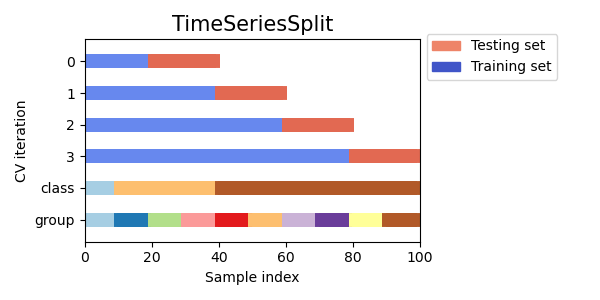

In [128]:
# here's my approach:
# for each model (there are four of them):
#   I do a cross-validation in order to get as many out-of-fold predictions as possible
#   I need those to train the ensemble model (the 5th model)
#   while I'm at it, I also capture the number of epochs / boosting rounds that are used
#   as I have a separated validation set and early stopping. 
#   after this, these models are not used.

#   I then use the epochs/num_boost_round to train on all the data, instead of reserving
#   some for early stopping. Some kagglers do it that way. 

# Also the way I do cross-validation is also a little unusual because it's time series data
# Instead of shuffling and assigning each row to a different fold as usual. This uses a 
# time series approach where the out of fold is always in the 'future' right after the 
# train fold. And each train fold is a slightly larger superset of the last train fold
# and lastly the last part of the dataset never is used for training since there are no future
# rows.  

# like this (at least the top part of this picture):
image(f('./data2/sphx_glr_plot_cv_indices_013.png'))

In [129]:
# let's do some CVing on each of the models to get out of fold predictions to ensembling
oof_predictions = {}

In [130]:
def show_error(model):
    print(f" {model} mae", 
        mean_absolute_error(oof_predictions[model]['yactuals'], 
                            oof_predictions[model]['ypred']))


In [131]:
def yield_splits(train):
    tscv = TimeSeriesSplit()
    all_dates_df = pd.DataFrame(train.index.get_level_values('date').unique())
    for train_index, valid_index in tscv.split(all_dates_df):

        print("TRAIN:", len(train_index), "TEST:", len(valid_index))
        train_dates = all_dates_df.iloc[train_index]['date']
        valid_dates = all_dates_df.iloc[valid_index]['date']
        train_mask = train.index.get_level_values('date').isin(train_dates)
        valid_mask = train.index.get_level_values('date').isin(valid_dates) 
        X_train = train[train_mask][feature_cols]
        y_train = train[train_mask][label]
        X_valid = train[valid_mask][feature_cols]
        y_valid = train[valid_mask][label]
        yield X_train, y_train, X_valid, y_valid

In [132]:
# model 1 - xgboost

In [133]:
param = {
    'objective':'reg:squarederror', 
    'verbosity': 0 }

In [134]:
# determine num_boost_rounds and out of fold predictions (for ensembling) vs. cv
model = 'xgboost'
oof_predictions[model] = pd.DataFrame()
best_iterations = []
iteration_weights = []

for X_train, y_train, X_valid, y_valid in yield_splits(train):
     
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    evallist = [(dtrain, 'train'), (dvalid, 'valid')]
    bst = xgb.train(param, dtrain, 1000, evallist, 
                    early_stopping_rounds=10, verbose_eval=False)
    print("  bst.best_iteration", bst.best_iteration)
    best_iterations.append(bst.best_iteration)
    iteration_weights.append(dtrain.num_row())
                        
    ypred = bst.predict(dvalid)
    this_fold = pd.DataFrame({"ypred": ypred, "yactuals": y_valid})
    oof_predictions[model] = oof_predictions[model].append(this_fold)


show_error(model)
num_boost_round = round(np.average(best_iterations, weights = iteration_weights))
"average boosting rounds", num_boost_round

TRAIN: 92 TEST: 90
  bst.best_iteration 34
TRAIN: 182 TEST: 90
  bst.best_iteration 11
TRAIN: 272 TEST: 90
  bst.best_iteration 75
TRAIN: 362 TEST: 90
  bst.best_iteration 13
TRAIN: 452 TEST: 90
  bst.best_iteration 49
 xgboost mae 122.91189057349277


('average boosting rounds', 39)

In [135]:
# train the real xgboost model on all data based on the num_boost_round 
dtrain = xgb.DMatrix(train[feature_cols], label=train[label])
print((dtrain.num_row(), dtrain.num_col()))
evallist = [(dtrain, 'train')]
bst = xgb.train(param, dtrain, num_boost_round, evallist, verbose_eval=100)

(32520, 17)
[0]	train-rmse:1840.15784
[38]	train-rmse:50.68531


In [136]:
# model 2 = just a LinearRegressor

In [137]:
model = 'linear'
oof_predictions[model] = pd.DataFrame()
train2 = train.copy().dropna() # can't handle the np.nan like xgboost can

for X_train, y_train, X_valid, y_valid in yield_splits(train2):     
    linear = LinearRegression().fit(X_train, y_train)
    ypred = linear.predict(X_valid)
    this_fold = pd.DataFrame({"ypred": ypred, "yactuals": y_valid})
    oof_predictions[model] = oof_predictions[model].append(this_fold)
show_error(model)

TRAIN: 93 TEST: 88
TRAIN: 181 TEST: 88
TRAIN: 269 TEST: 88
TRAIN: 357 TEST: 88
TRAIN: 445 TEST: 88
 linear mae 39.69425568681284


In [138]:
# now train on all
linear = LinearRegression().fit(train2[feature_cols], train2[label])

In [139]:
# model 3 - plain feed forward neural network

In [140]:
%%time
if 'ann' in INCLUDE_MODELS:
    model = 'ann'
    oof_predictions[model] = pd.DataFrame()
    best_iterations = []
    iteration_weights = []
    train2 = train.copy().dropna() # can't handle the np.nan like xgboost can

    def make_model(n_in):
        inp = L.Input(name="inputs", shape=(n_in,))
        x = L.Dense(50, activation="relu", name="d1")(inp)
        x = L.Dense(50, activation="relu", name="d2")(x)
        preds = L.Dense(1, activation="linear", name="preds")(x)

        model = M.Model(inp, preds, name="ANN")
        model.compile(loss="mean_absolute_error", optimizer="adam")
        return model


    for X_train, y_train, X_valid, y_valid in yield_splits(train2):   

        X_scaler = StandardScaler()
        X_train = X_scaler.fit_transform(X_train)
        X_valid = X_scaler.transform(X_valid)
        y_scaler = StandardScaler()
        y_train = y_scaler.fit_transform(y_train.to_frame())
        y_valid_scaled = y_scaler.transform(y_valid.to_frame())
        net = make_model(X_train.shape[1])
        es = EarlyStopping(monitor='val_loss', patience=10)
        reduce_lr = ReduceLROnPlateau() #monitor='val_loss', factor=0.2,patience=3, min_lr=0.0005)
        epochs = ANN_EPOCHS
        net.fit(X_train, y_train, epochs=epochs, batch_size=35_000, validation_data=(
            X_valid, y_valid_scaled), verbose=0, callbacks=[es, reduce_lr])
        stopped_epoch = es.stopped_epoch if es.stopped_epoch > 0 else epochs
        print("  es.stopped_epoch", stopped_epoch)
        best_iterations.append(stopped_epoch)
        iteration_weights.append(X_train.shape[0])
        ypred_scaled = net.predict(X_valid, batch_size=50_000)
        ypred = y_scaler.inverse_transform(ypred_scaled).flatten()
        this_fold = pd.DataFrame({"ypred": ypred, "yactuals": y_valid})
        oof_predictions[model] = oof_predictions[model].append(this_fold)
    show_error(model)
    epochs = round(np.average(best_iterations, weights = iteration_weights))
    "average epochs", epochs

TRAIN: 93 TEST: 88


2021-10-04 07:51:18.720277: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-04 07:51:18.720752: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 16. Tune using inter_op_parallelism_threads for best performance.


  es.stopped_epoch 245
TRAIN: 181 TEST: 88
  es.stopped_epoch 301
TRAIN: 269 TEST: 88
  es.stopped_epoch 363
TRAIN: 357 TEST: 88
  es.stopped_epoch 25
TRAIN: 445 TEST: 88
  es.stopped_epoch 231
 ann mae 104.61260488631979
CPU times: user 3min 24s, sys: 13min 28s, total: 16min 52s
Wall time: 1min 6s


In [141]:
%%time
# now train on all
if 'ann' in INCLUDE_MODELS:
    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(train2[feature_cols])
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(train2[label].to_frame())
    net = make_model(X_train.shape[1])
    reduce_lr = ReduceLROnPlateau(monitor='loss') #, factor=0.2,patience=3, min_lr=0.0005)
    net.fit(X_train, y_train, epochs=epochs, batch_size=35_000, 
            verbose=0, callbacks=[reduce_lr])

CPU times: user 31.1 s, sys: 22.2 s, total: 53.3 s
Wall time: 3.83 s


In [142]:
# model 4

In [143]:
def shape_data(arr):
    data = []
    for i in range(len(arr) - TIME_STEPS):
        data.append(arr[i:i + TIME_STEPS + 1])
    data = np.array(data)
    assert len(data.shape) == 3
    return data

class LSTM_Pipeline:
    
    def __init__(self, metric_name):
        self.metric_name = metric_name
        self.prior_predictions = pd.DataFrame()
    
    def fit(self, X_and_y):

        self.y_scaler = StandardScaler()
        self.y_scaler.fit(X_and_y[[self.metric_name]])
        self.prior_dates = X_and_y.copy()

    def add_cartesian(self, df):
        # make sure every combination of date and entity is there.  This may not be a problem anyway
        # but just checking for now.
        if df.shape[0] != (
            df.index.get_level_values('date').nunique() * 
            df.index.get_level_values('entity').nunique()):
                date_df = df.reset_index()[['date']].drop_duplicates() # all dates.
                entity_df = df.reset_index()[['entity']].drop_duplicates() # all entities
                cross_df = date_df.merge(entity_df, how='cross') # cartesian product
                # now bring in the data
                df = cross_df.set_index(['date', 'entity']).join(df)
        return df
        
    
    def transform(self, X_and_y):
        
        X_and_y_cartesian = self.add_cartesian(X_and_y.copy())
        df = X_and_y_cartesian.copy()
        # for now, let's get town to 2 features - label and is_weekday

        df['is_weekday'] = (df.index.get_level_values('date').dayofweek < 5).astype(int)
        df[self.metric_name] = self.y_scaler.transform(df[[self.metric_name]])

        df = df[[self.metric_name, 'is_weekday']] # LABEL NEEDS TO BE FIRST

        
        # now we are going to try using numpy.  
        # look through the entities.  
        # for each entity take the 2-D array (date in the rows and features in the columns)
        # and add a 3rd dimension - the timestep.  
        # this is using the telemanom code.  
        entities = df.index.get_level_values('entity').unique()
        all_data = []
        for entity in entities:
            data_for_this_entity = df[df.index.get_level_values('entity') == entity].values
            assert len(data_for_this_entity.shape) == 2
            # change data to 3d as (n dates, n timesteps, n features)
            data_3d = shape_data(data_for_this_entity)
            assert len(data_3d.shape) == 3
            all_data.append(data_3d)
        data_4d = np.array(all_data)
        # now the data is 4d as (n entities, n dates, n timesteps, n features)

        return data_4d, X_and_y_cartesian
    
    def transform_test(self, X):
        prior_predictions = self.prior_predictions.copy()
        if not PREDICT_WITH_ACTUALS:
            pdb.set_trace() # watch this once.
            prior_predictions.rename(
                columns={f"ypred_{self.metric_name}": self.metric_name}, inplace=True)
        prior_predictions.drop(
            columns=[f"ypred_{self.metric_name}"], inplace=True, errors='ignore')
        X2 = self.prior_dates.append(prior_predictions)
        X2 = X2.append(X) # put the history on the front
        full_data, _ = self.transform(X2) # n_entities, n_dates, n_timesteps, n_features
        # only need last date and not the last timestep (that's the label)
        one_date_3d = full_data[:, -1, :-1, :]
        return one_date_3d
    
    def unscale_y(self, y):
        scaler = self.y_scaler
        if type(y) != np.ndarray:
            pdb.set_trace()
        return self.y_scaler.inverse_transform(y.reshape(-1, 1))[:,0]
    
    def register_prediction(self, df):
        self.prior_predictions = self.prior_predictions.append(df)
        

In [144]:
model = 'lstm'
my_lstm_pipeline = LSTM_Pipeline(label)
my_lstm_pipeline.fit(train)
train_4d, train_lstm = my_lstm_pipeline.transform(train)

def make_lstm(n_features):


    lstm_model = Sequential()

    lstm_model.add(LSTM(80, input_shape=(None, n_features), return_sequences=True))
    lstm_model.add(Dropout(0.3))

    lstm_model.add(LSTM(80, return_sequences=False))
    lstm_model.add(Dropout(0.3))

    lstm_model.add(Dense(1))
    lstm_model.add(Activation('linear'))

    lstm_model.compile(loss='mean_absolute_error', optimizer='adam')
    return lstm_model

In [ ]:
%%time
if 'lstm' in INCLUDE_MODELS:
    oof_predictions[model] = pd.DataFrame()
    best_iterations = []
    iteration_weights = []

    tscv = TimeSeriesSplit()

    dates_len = train_4d.shape[1] # number of dates

    for train_dates, valid_dates in tscv.split(range(dates_len)):

        print("TRAIN:", len(train_dates), "TEST:", len(valid_dates))


        # the last timestep is the label (referenced here by -1)
        # label should be the first feature (see above),  (referenced here by the 0)
        # X_train_4d.reshape(-1, X_train_4d.shape[2], X_train_4d.shape[3]).shape
        # get the index right
        actual_valid_dates = train_lstm.index.get_level_values('date').unique()[valid_dates]
        valid_index = train_lstm[train_lstm.index.get_level_values('date').isin(
            actual_valid_dates)].index
        X_train_3d = (train_4d[:, train_dates, :-1, :].reshape(
            -1, 
            train_4d.shape[2] - 1, # # of timesteps
            train_4d.shape[3]) # # of features
                     )
        X_valid_3d = (train_4d[:, valid_dates, :-1, :].reshape(
            -1, 
            train_4d.shape[2] - 1, # # of timesteps
            train_4d.shape[3]) # # of features
                     )
        y_train_2d = train_4d[:, train_dates, -1, 0].reshape(-1, 1)
        y_valid_2d = train_4d[:, valid_dates, -1, 0].reshape(-1, 1)

        lstm_model = make_lstm(X_train_3d.shape[2])
        es = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0003, verbose=0)
        cbs = [History(), es]
        epochs = LSTM_EPOCHS 
        lstm_model.fit(X_train_3d,
                       y_train_2d,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(X_valid_3d, y_valid_2d),
                       callbacks=cbs,
                       verbose=True)
        stopped_epoch = es.stopped_epoch if es.stopped_epoch > 0 else epochs
        print("\tes.stopped_epoch", stopped_epoch)
        best_iterations.append(stopped_epoch)
        iteration_weights.append(X_train_3d.shape[0])
        ypred_scaled = lstm_model.predict(X_valid_3d)
        ypred = my_lstm_pipeline.unscale_y(ypred_scaled.flatten())
        yactuals = my_lstm_pipeline.unscale_y(y_valid_2d.flatten())
        this_fold = pd.DataFrame({"ypred": ypred, "yactuals": yactuals}, index=valid_index)
        print("\tfold mae", mean_absolute_error(this_fold['yactuals'], this_fold['ypred']))
        oof_predictions[model] = oof_predictions[model].append(this_fold)
    show_error(model)
    lstm_epochs = round(np.average(best_iterations, weights = iteration_weights))
    "average epochs", lstm_epochs

    obj = {
        "oof_predictions": oof_predictions[model],
        "lstm_epochs": lstm_epochs}
    pickle.dump(obj, open("lstm_saved", "wb"))

TRAIN: 92 TEST: 88


In [ ]:
if 'lstm' in INCLUDE_MODELS:
    obj = pickle.load(open("lstm_saved", "rb"))
    oof_predictions[model] = obj['oof_predictions']
    lstm_epochs = obj['lstm_epochs']

In [ ]:
%%time
if 'lstm' in INCLUDE_MODELS:
    # now train on all
    X_3d = (train_4d[:, :, :-1, :].reshape(-1, 
        train_4d.shape[2] - 1, # # of timesteps
        train_4d.shape[3]) # # of features
                 )
    y_2d = train_4d[:, :, -1, 0].reshape(-1, 1)
    lstm_model = make_lstm(X_3d.shape[2])

    lstm_model.fit(X_3d,
                   y_2d,
                   batch_size=64,
                   epochs=lstm_epochs,
                   verbose=True)

In [ ]:
oof_predictions.keys()

In [ ]:
# # not needed - just for sanity checking
# ypred_scaled = lstm_model.predict(X_3d)
# ypred = my_lstm_pipeline.unscale_y(ypred_scaled.flatten())
# yactuals = my_lstm_pipeline.unscale_y(y_2d.flatten())
# print("training mae", mean_absolute_error(ypred, yactuals))

In [ ]:
# ensemble these models
# this last model is a nice piece-wise linear model called LassoLarsCV.  
# It has an CV process internal to itself and sets its optimal parameters.

# this ensemble is essentially using the out-of-fold predictions as the Xs and the real 
# value as the 
# y. and determining the best function(X), as usual in ML, to calculate the y. So it's 
# deciding in what way to combine the predictions of the underlying submodels (the weights
# in linear model lingo)

df = None
for model, oof_df in oof_predictions.items():
    if model in INCLUDE_MODELS:
        oof_df2 = oof_df.rename(columns={"ypred": f"ypred_{model}"})
        if df is None:
            df = oof_df2
        else:
            df = df.join(oof_df2.drop(columns='yactuals'), how='inner')
        
class LassoEnsemble():
            
    def fit(self, X, y):
        assert type(X) == pd.DataFrame
        self.ensemble_model = LassoLarsCV(cv=5)
        self.ensemble_model.fit(X, y)
        self.X_columns = X.columns
        self.coef_ = self.ensemble_model.coef_
        
    def predict(self, X):
        assert type(X) == pd.DataFrame
        X2 = X[self.X_columns]
        return self.ensemble_model.predict(X2)
        
    def coef_(self):
        return self.ensemble_model.coef_
        
ensemble_model = LassoEnsemble()
X = df.drop(columns='yactuals')
y = df['yactuals']
ensemble_model.fit(X, y)

In [ ]:
# do testing kaggle-style

test_dates = sorted(test.index.get_level_values('date').unique())
predictions = pd.DataFrame()
test_with_features = pd.DataFrame()
all_model_predictions = pd.DataFrame()
for date in test_dates:
    print(date, end=", ", flush=True)
    test_one_date = test[test.index.get_level_values('date') == date].copy()

    test_one_date = myTSPipline.transform_test(test_one_date)
    
    # predict using the different models
    ypreds = pd.DataFrame(index=test_one_date.index)
    
    if 'linear' in INCLUDE_MODELS:  
        ypreds["ypred_linear"] = linear.predict(test_one_date[feature_cols])
    
    if 'xgboost' in INCLUDE_MODELS: 
        dtest = xgb.DMatrix(test_one_date[feature_cols])
        ypreds["ypred_xgboost"] = bst.predict(dtest)
        
    if 'ann' in INCLUDE_MODELS:     
        ypreds['ypred_ann'] = net.predict(X_scaler.transform(test_one_date[feature_cols]))
        ypreds['ypred_ann'] = y_scaler.inverse_transform(
            ypreds['ypred_ann'].to_frame())[:,0]
        
    if 'lstm' in INCLUDE_MODELS:   
        test_3d = my_lstm_pipeline.transform_test(test_one_date[feature_cols])
        a0 = lstm_model.predict(test_3d).flatten()
        ypreds['ypred_lstm'] = my_lstm_pipeline.unscale_y(a0)
        
    all_model_predictions = all_model_predictions.append(ypreds)
  
    ypred = ensemble_model.predict(ypreds)
    this_prediction = test_one_date.copy()
    this_prediction[f'ypred_{label}'] = ypred
    predictions = predictions.append(this_prediction)

    test_one_date[label] = test.loc[test_one_date.index][label]
    test_one_date[f'ypred_{label}'] = ypred
    
    myTSPipline.register_prediction(test_one_date)
    my_lstm_pipeline.register_prediction(test_one_date)
    
    test_with_features = test_with_features.append(test_one_date)

In [ ]:
f'ypred_{metric_cols[0]}' in test
test.columns, f'{metric_cols[0]}'

In [ ]:
all_model_predictions.join(test[metric_cols[0]]).to_csv(
    'all_model_predictions_30Sep2021.csv')

In [ ]:
# search entity
if str(source_path) == 'covid-new-cases.csv':
    entity_for_graphs = 'MA'
if str(source_path) == 'djia.csv':    
    entity_for_graphs = 'GE'
    # entity_for_graphs = 'GOOGL'
    entity_for_graphs = 'AMZN'
if str(source_path) == 'whiskey.csv':
    entity_for_graphs = 'Ireland'
if str(source_path) == 'nyc_crime.csv':
    entity_for_graphs = 'P-018'
assert entity_for_graphs in train.index.get_level_values('entity')

In [ ]:
# search four
train[train.index.get_level_values('entity') == entity_for_graphs]

In [ ]:
predictions.reset_index().query(f"entity == '{entity_for_graphs}'").head()

In [ ]:
if f'ypred_{metric_cols[0]}' not in test:
    test = test.join(predictions[f'ypred_{metric_cols[0]}'])

In [ ]:
"test mae", mean_absolute_error(test[metric_cols[0]], test[f'ypred_{metric_cols[0]}'])

In [ ]:
test.reset_index().query(f"entity == '{entity_for_graphs}'")

In [ ]:
display

In [ ]:
# feature importance - for xgb at least.
xgb.plot_importance(bst, max_num_features=10) # search feature importance

In [ ]:
def save_entity(entity, extra_cols = []):
    
    assert type(extra_cols) == list
    cols = metric_cols + [f"ypred_{c}" for c in metric_cols] + extra_cols
    train_copy = train.copy()
    for col in cols:
        if col not in train:
            train[col] = None
    all_df = train[cols].append(test[cols])

    all_df = (all_df
     .reset_index()
     .query(f'entity == "{entity}"')
     .drop(columns='entity')
     .sort_values('date')
#      .rename(columns={metric_cols[0]: f"{entity} {metric_cols[0]}"})
     
    )
    all_df.to_csv(f'{entity}_{metric_cols[0]}.csv', index=False)
    return all_df
all_df = save_entity(entity_for_graphs)

In [ ]:
all_df.columns

In [ ]:
# draw train only
df = all_df[all_df['date'].isin(train.index.get_level_values('date').unique())].copy() # train only
def draw_lineplot(df):
        
    df['date'] = pd.to_datetime(df['date'].astype(str))
    df.set_index('date', inplace=True)

    sns.set_theme(style="whitegrid")
    sns.set(rc = {'figure.figsize':(15,8)})
    sns.lineplot(data=df, palette="tab10", linewidth=2.5).set_title(
        f"{entity_for_graphs} {metric_cols[0]}")
    plt.xlim(
        df.index[0], 
        all_df['date'].iloc[-1].to_timestamp() + timedelta(days=test.index.get_level_values('date').nunique()))

    plt.axvline(test.index.get_level_values('date')[0].to_timestamp(), 0, 1, color='green')
draw_lineplot(df) # search results

In [ ]:
# draw predictions only
df = all_df.copy()
df
pred_col = f"ypred_{metric_cols[0]}"
pred_col
def fn(row):
    if np.isnan(row[pred_col]):
        return row[metric_cols[0]]
    else:
        return np.nan
df[metric_cols[0]] = df.apply(fn, axis=1)
df
draw_lineplot(df)

In [ ]:
# draw all
df = all_df.copy()
draw_lineplot(df)

In [ ]:
# zoom in
df = all_df.copy()
pred_col = f"ypred_{metric_cols[0]}"
df.dropna(subset=[pred_col], inplace=True)
draw_lineplot(df)

In [ ]:
# determine what is an anomaly using the error mean/std and calling 2 stds away an 
# anomaly. You could of course tune this up or down.

error_series = (test[metric_cols[0]] - test[f'ypred_{metric_cols[0]}'])
error_stats = error_series.describe()
mean, std = error_stats['mean'], error_stats['std']
lcl = mean - (2 * std)
ucl = mean + (2 * std)
lcl, ucl

In [ ]:
test['anomaly_by_ml'] = ((error_series < lcl) | (error_series > ucl))
test['anomaly_by_ml'].sum(), test.shape[0]

In [ ]:
def show_anomaly_pivot(anomaly_col):
    def highlight_anomaly(row):
        highlight = 'background-color: lightcoral;'
        default = ''
        styles = []
        for col, date in row.index:
            if col == metric_cols[0] and row[(anomaly_col, date)]:
                styles.append(highlight)
            else:
                styles.append(default)
        return styles
    
    test2 = test.copy().reset_index()
    metric_col = metric_cols[0]
    if dtype_for_pivot == int:
        test2[metric_col] = test2[metric_col].astype(int)

    test_pivot = (test2[['date', 'entity', metric_col, anomaly_col]]
     .pivot(index='entity', columns='date', values=[metric_col, anomaly_col])
    )
    test_pivot.reset_index(inplace=True)
    test_pivot['Entity'] = test_pivot['entity']
    hidden_cols = [c for c in test_pivot.columns if c[0] == anomaly_col]
    test_style = (test_pivot
     .style.apply(highlight_anomaly, axis=1)
     .hide_columns(hidden_cols)
    )
    return test_style
show_anomaly_pivot('anomaly_by_ml') # search by ml

In [ ]:
save_entity(entity_for_graphs, ['anomaly_by_ml'])

In [ ]:
print("test mae", mean_absolute_error(test[metric_cols[0]], test[f'ypred_{metric_cols[0]}']))

In [ ]:
import time; time.ctime(); print(time.strftime('%I:%M:%S%p %Z on %b %d, %Y'))

In [ ]:
# add other columns based on Date (e.g. day of week) and entity (e.g. entity encoded)
# Do slides!
# figure out auto-thresholding
# do multiple metrics (like the covid example in case some are leading and lagging)
# normalize the metrics so the entities better learn from each other
# go back and get rid of pngs earlier in notebook
# get some good seasonality examples
# try predict on predictions again

In [ ]:
print("that took", (datetime.now() - start_time).seconds, "seconds")